### **Projet Python pour la data-science : prévision des prix de l'immobilier**

Réalisé par Clémence Chevrier et Soline Mignot

# **1. Import des modules et des bases de données**

# 1.1 Import des modules

In [133]:
%pip install geopandas
%pip install statsmodels
import statsmodels.api as sm
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
import scipy
from scipy.stats import norm
import pandas as pd
import warnings
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.cross_decomposition import CCA
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# 1.2 Import des bases de données


On importe les données de demande de valeurs foncières géolocalisées depuis le site data.gouv.fr.

In [3]:
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/2022/full.csv.gz'
df= pd.read_csv(url, sep=',',low_memory=False)

In [4]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2022-1,2022-01-03,1,Vente,55000.0,13.0,NaN,RUE DE LA LIBERTE,2280,1000.0,...,Appartement,24.0,1.0,NaN,NaN,NaN,NaN,NaN,5.218712,46.198053
1,2022-2,2022-01-03,1,Vente,143000.0,NaN,NaN,CHAMP COCHET,B010,1480.0,...,NaN,NaN,NaN,S,sols,NaN,NaN,84.0,4.847863,46.000587
2,2022-2,2022-01-03,1,Vente,143000.0,NaN,NaN,CHAMP COCHET,B010,1480.0,...,NaN,NaN,NaN,S,sols,NaN,NaN,88.0,4.847924,46.000581
3,2022-2,2022-01-03,1,Vente,143000.0,98.0,NaN,RTE DE LA DOMBES,0055,1480.0,...,Appartement,140.0,3.0,NaN,NaN,NaN,NaN,NaN,4.848340,46.000631
4,2022-3,2022-01-04,1,Vente,300.0,NaN,NaN,AUX PIERRES,B031,1480.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,510.0,4.747594,46.045423


# **2. Nettoyage de la base de données**

## 2.1 Extraction des colonnes utiles

Nous souhaitons nettoyer la base de données. Pour commencer, nous affichons toutes les colonnes pour pouvoir retirer celles qui nous seront inutiles.

In [5]:
df.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [6]:
df=df.drop( columns=['numero_disposition','adresse_numero', 'adresse_suffixe', 'adresse_code_voie', 'code_postal','code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale','id_parcelle', 'ancien_id_parcelle','numero_volume','code_type_local','lot1_numero', 'lot1_surface_carrez', 'lot2_numero','lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez','lot4_numero', 'lot4_surface_carrez', 'lot5_numero','lot5_surface_carrez'], axis=1)

In [7]:
df.info(null_counts= True)

<ipython-input-7-07af6ba031d6>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts= True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617590 entries, 0 to 4617589
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id_mutation                4617590 non-null  object 
 1   date_mutation              4617590 non-null  object 
 2   nature_mutation            4617590 non-null  object 
 3   valeur_fonciere            4586448 non-null  float64
 4   adresse_nom_voie           4578915 non-null  object 
 5   code_commune               4617590 non-null  object 
 6   nom_commune                4617590 non-null  object 
 7   code_departement           4617590 non-null  object 
 8   ancien_code_commune        40 non-null       float64
 9   ancien_nom_commune         40 non-null       object 
 10  nombre_lots                4617590 non-null  int64  
 11  type_local                 2740862 non-null  object 
 12  surface_reelle_bati        1529601 non-null  float64
 13  nombre_piece

## 2.2 Modification de la base de données en fonction des variables type_local et nature_mutation

Maintenant, intéressons nous à la variable type_local, qui répertorie si le batîment vendu est une maison, un appartement, une dépendance ou un local industriel. Pour cela, affichons la répartition de cette variable.

In [8]:
df['type_local'].value_counts(dropna = False, normalize = True).head()

NaN                                         0.406430
Dépendance                                  0.260621
Maison                                      0.163724
Appartement                                 0.138358
Local industriel. commercial ou assimilé    0.030868
Name: type_local, dtype: float64

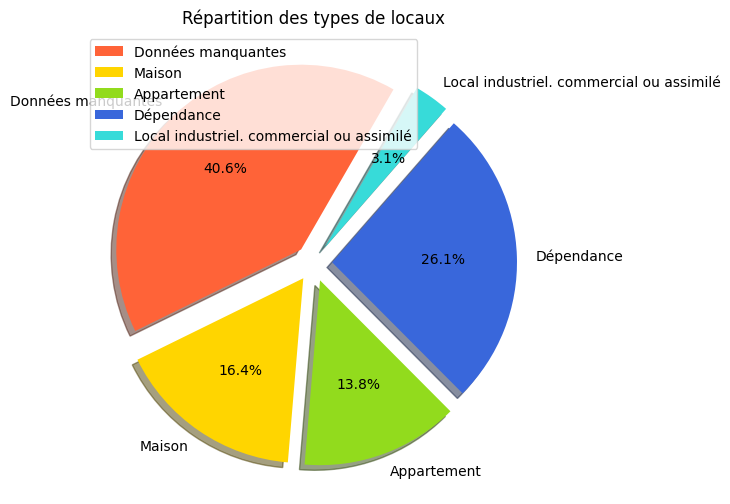

In [9]:
plt.figure(figsize=(6,6))
labels = ['Données manquantes', 'Maison', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé']
colors = ['#ff6338','#ffd500','#92db1d','#3967db','#37dbd9']
area = [40.6, 16.4, 13.8, 26.1, 3.1]
explode = (0.1,0.1,0.1,0.1,0.1)
plt.pie(area, labels=labels, explode=explode, colors= colors, startangle=60, autopct='%1.1f%%',shadow='True')
plt.title(label= 'Répartition des types de locaux')
plt.legend()
plt.show()

Maintenant, faisons la même chose avec la nature des mutations.

In [10]:
df['nature_mutation'].value_counts(dropna = False, normalize = True).head()

Vente                                 0.924123
Vente en l'état futur d'achèvement    0.060762
Echange                               0.009789
Vente terrain à bâtir                 0.003090
Adjudication                          0.002041
Name: nature_mutation, dtype: float64

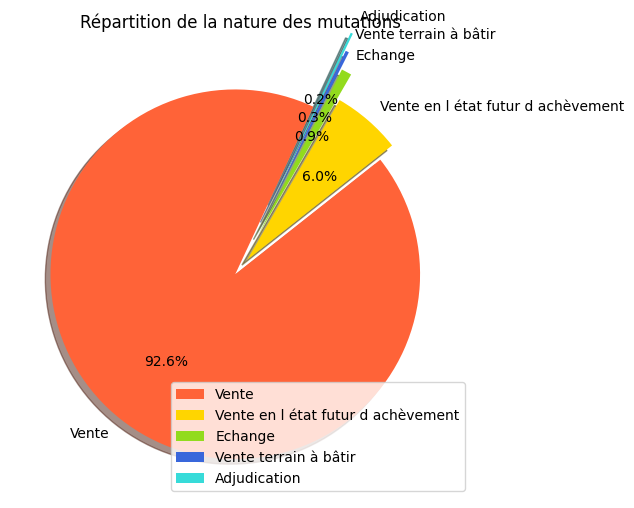

In [11]:
plt.figure(figsize=(6,6))
labels = ['Vente', 'Vente en l état futur d achèvement', 'Echange', 'Vente terrain à bâtir','Adjudication']
colors = ['#ff6338','#ffd500','#92db1d','#3967db','#37dbd9']
area = [92.4,6.0,0.9,0.3,0.2]
explode = (0.05,0.05,0.2,0.3,0.4)
plt.pie(area, labels=labels, explode=explode, colors= colors, startangle=65, autopct='%1.1f%%',shadow='True')
plt.title(label= 'Répartition de la nature des mutations')
plt.legend()
plt.show()

Il y a beaucoup de données manquantes (40.6%) pour les types de locaux. Nous décidons donc d'enlever ces données de la base, ainsi que celles correspondant à un local industriel. On souhaite également garder uniquement les données correspondant à une vente, pour ne pas inclure des transactions sur des biens qui n'ont pas encore été construits ou achevés, comme les ventes en l'état futur d'achèvement. En effet, ces transactions peuvent avoir des caractéristiques différentes de celles des biens existants, ce qui peut biaiser l'analyse si elles sont mélangées dans la même étude. On retire donc les données qui ne vont pas nous servir. De plus, nous retirons de la base de données les données dont la surface associée est de 0m² pour pouvoir calculer le prix au mètre carré correctement.

In [12]:
df=df[df['surface_reelle_bati']!=0]
df=df.loc[df['type_local'].isin(['Maison','Appartement','Dépendance'])]
df=df.loc[df['nature_mutation'].isin(['Vente'])]
df=df.drop_duplicates()
df.dropna(subset=['valeur_fonciere','surface_reelle_bati','nombre_pieces_principales'], inplace=True)

<ipython-input-12-dc65b5af3ce4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['valeur_fonciere','surface_reelle_bati','nombre_pieces_principales'], inplace=True)


## 2.3 Elimination des valeurs aberrantes par prix du mètre carré

Maintenant, nous souhaitons calculer le prix par mètre carré dans le but d'éliminer les valeurs aberrantes.

In [13]:
df['prix_au_metre_carre'] = df['valeur_fonciere'] / df['surface_reelle_bati']

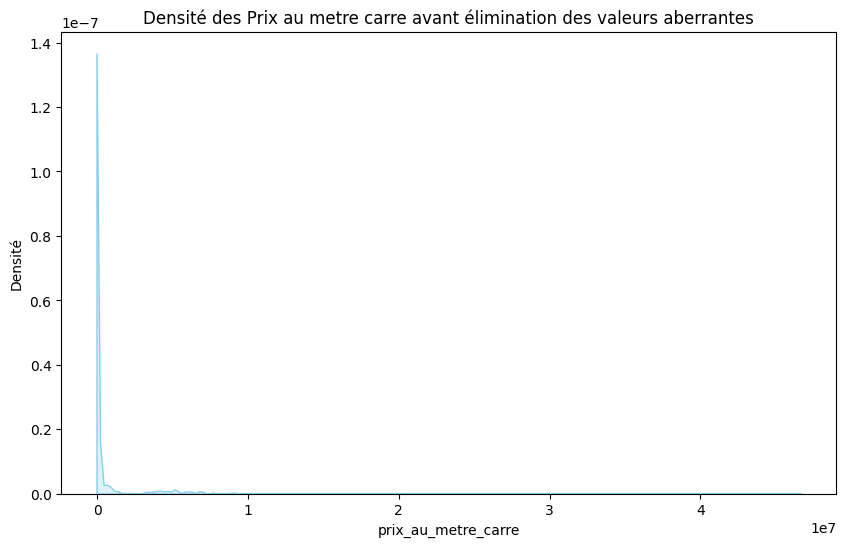

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['prix_au_metre_carre'], fill=True, color='skyblue')
plt.xlabel('prix_au_metre_carre')
plt.ylabel('Densité')
plt.title('Densité des Prix au metre carre avant élimination des valeurs aberrantes')
plt.show()

La visibilité sur le prix au mètre carré que procure cette distribution n'est pas très bonne, c'est pourquoi nous allons éliminer les valeurs aberrantes, également appelées outliers. Nous allons nous baser sur l'écart interquartile, IQR, qui est la place entre le premier quartier et le troisième quartile.

In [15]:
df.columns

Index(['id_mutation', 'date_mutation', 'nature_mutation', 'valeur_fonciere',
       'adresse_nom_voie', 'code_commune', 'nom_commune', 'code_departement',
       'ancien_code_commune', 'ancien_nom_commune', 'nombre_lots',
       'type_local', 'surface_reelle_bati', 'nombre_pieces_principales',
       'surface_terrain', 'longitude', 'latitude', 'prix_au_metre_carre'],
      dtype='object')

In [16]:
data=df.copy()
data.drop(columns=['id_mutation', 'nature_mutation', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'nombre_lots', 'type_local',
       'longitude', 'latitude'],axis=1).describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,prix_au_metre_carre
count,1307206.00000,1307206.00000,1307206.00000,806749.00000,1307206.00000
mean,1357260.18110,83.47727,3.50550,929.18999,22758.25095
std,17634699.57564,47.28634,1.61382,5779.84327,330409.73236
min,0.15000,1.00000,0.00000,1.00000,0.00101
1%,17000.00000,16.00000,1.00000,35.00000,261.36563
25%,123030.25000,51.00000,2.00000,252.00000,1709.87654
50%,200000.00000,76.00000,3.00000,500.00000,2712.32877
75%,330000.00000,104.00000,4.00000,856.00000,4413.49802
95%,837000.00000,166.00000,6.00000,2400.00000,12173.91304
99%,3900000.00000,242.00000,8.00000,7995.00000,71370.58824


In [17]:
column='prix_au_metre_carre'
Q1=data[column].quantile(0.25)
Q3 = data[column].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df= df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

On voit que cette méthode ne retire pas de valeurs du côté inférieur de la distribution, car la distribution de la colonne 'prix_au_metre_carre' est telle que les valeurs aberrantes se trouvent principalement du côté supérieur de la distribution. Alors, la borne inférieure définie par Q1 - 1.5 * IQR est inférieure à la valeur minimale dans la colonne, n'excluant ainsi aucune valeur dans la partie inférieure.

In [18]:
df.drop(columns=['id_mutation', 'nature_mutation', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'nombre_lots', 'type_local',
       'longitude', 'latitude'],axis=1).describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,prix_au_metre_carre
count,1186464.00000,1186464.00000,1186464.00000,744840.00000,1186464.00000
mean,231113.42607,86.06045,3.60574,844.47082,2873.72571
std,186054.01725,46.30657,1.58828,5128.03996,1712.88532
min,0.15000,1.00000,0.00000,1.00000,0.00101
1%,15000.00000,18.00000,1.00000,34.00000,240.77807
25%,116500.00000,56.00000,3.00000,255.00000,1621.33333
50%,185100.00000,80.00000,4.00000,500.00000,2500.00000
75%,290000.00000,106.00000,5.00000,842.00000,3791.14855
95%,560000.00000,167.00000,6.00000,2187.00000,6400.00000
99%,914500.00000,241.00000,8.00000,6610.00000,7931.03448


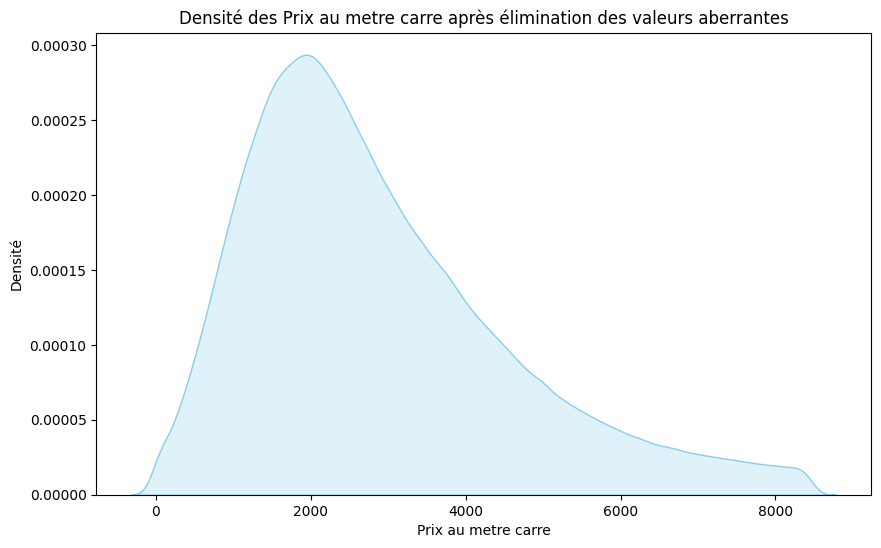

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['prix_au_metre_carre'], fill=True, color='skyblue')
plt.xlabel('Prix au metre carre')
plt.ylabel('Densité')
plt.title('Densité des Prix au metre carre après élimination des valeurs aberrantes')
plt.show()

# **3. Statistiques descriptives**


## 3.1 Premières statistiques

Dans la suite de notre projet, nous aurons besoin d'avoir une base de données uniquement dédiée à l'Ile de France. Alors, nous avons décidé d'avoir deux bases de données, une pour l'Ile de France, et une pour toute la France.

### 3.1.1 Statistiques sur la France entière

In [20]:
df['valeur_fonciere'].describe()

count    1.186464e+06
mean     2.311134e+05
std      1.860540e+05
min      1.500000e-01
25%      1.165000e+05
50%      1.851000e+05
75%      2.900000e+05
max      8.403500e+06
Name: valeur_fonciere, dtype: float64

Après avoir éliminé les valeurs aberrantes, on remarque que le prix moyen d'un bien immobilier en France est de 231 113 €, avec un prix maximal de 8 403 500€, ce qui parait plutôt cohérent. Cependant, le prix minimal est de 0.15€, ce qui détonne avec les prix du marché, et peut être dû à un prix symbolique ou à un programme de subvention.

Nous avons aperçu la répartition des prix au mètre carré lorsque nous avons éliminé les valeurs aberrantes plus tôt, mais maintenant, traçons la répartition des valeurs foncières en France.

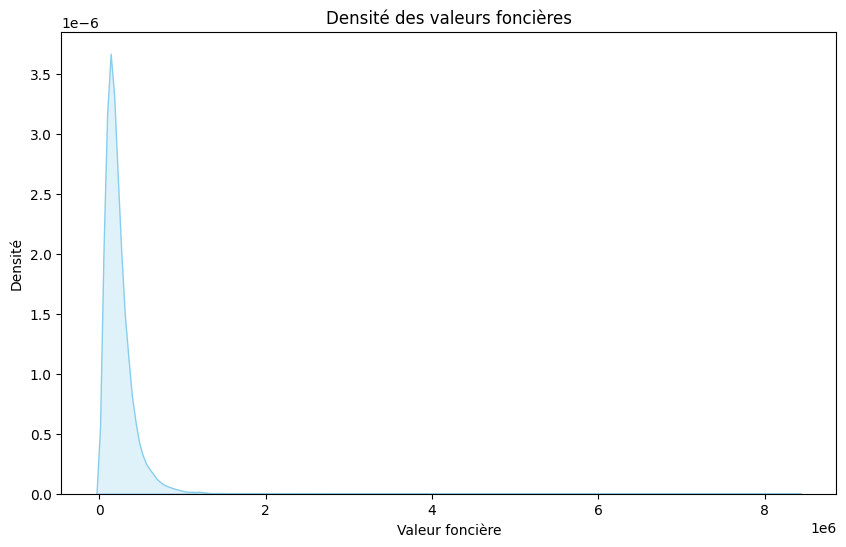

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['valeur_fonciere'], fill=True, color='skyblue')
plt.xlabel('Valeur foncière')
plt.ylabel('Densité')
plt.title('Densité des valeurs foncières')
plt.show()

In [22]:
quantile_value = np.percentile(df['valeur_fonciere'], 98)
quantile_value

750000.0

In [23]:
len(df.loc[df['valeur_fonciere']<400000])/len(df) * 100

87.5596731127114

On observe avec les calculs ci-dessus, que 87.5% des biens ont un prix inférieur à 400 000€ et que seuls 2% ont un prix supérieur à 750 000€. Nous allons donc tracer les distributions de prix selon ces seuils.

Text(0.5, 1.0, 'Distribution des prix supérieurs à 750 000 euros')

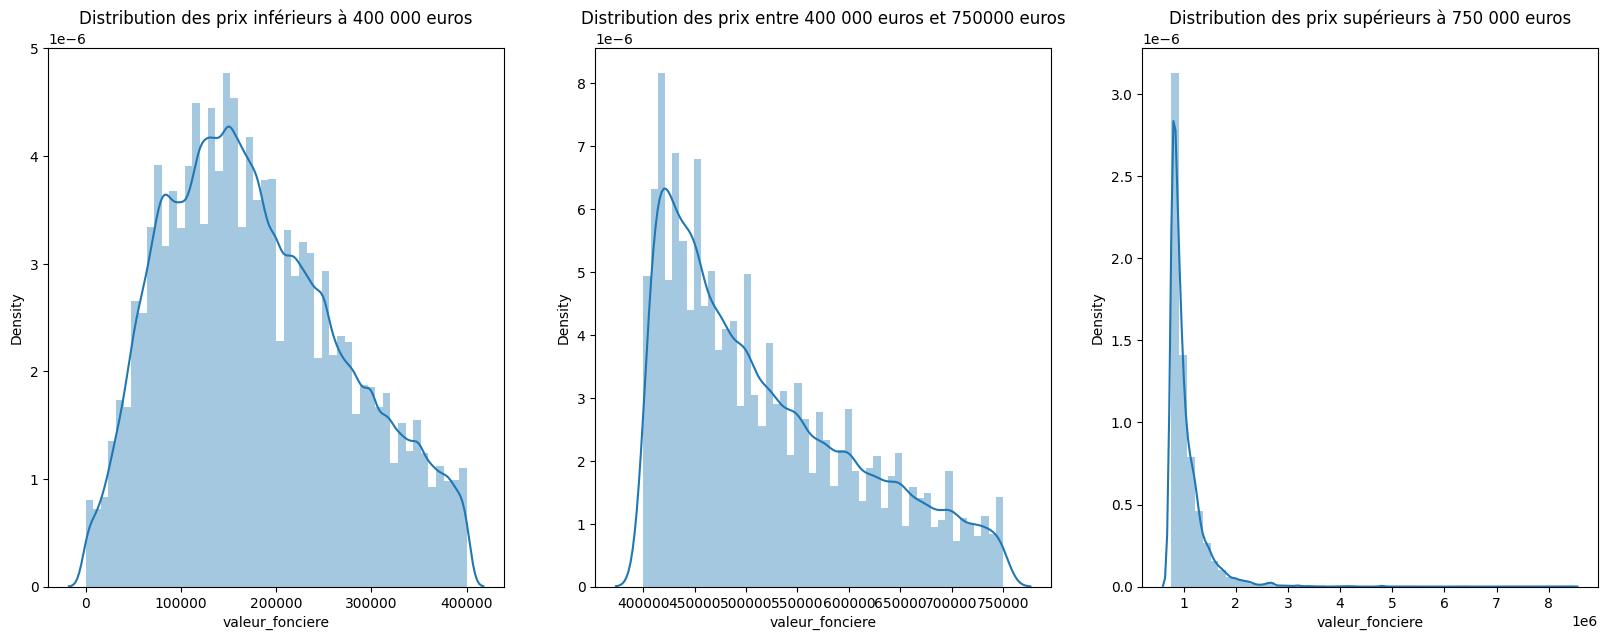

In [24]:
warnings.simplefilter('ignore')

fig, axs = plt.subplots(ncols=3, figsize=(20, 7))

ax0 = sns.distplot(df[df['valeur_fonciere'] <= 400000]['valeur_fonciere'], ax=axs[0])
ax0.set_title('Distribution des prix inférieurs à 400 000 euros')

ax1 = sns.distplot(df[(df['valeur_fonciere'] > 400000) & (df['valeur_fonciere'] <= 750000)]['valeur_fonciere'], ax=axs[1])
ax1.set_title('Distribution des prix entre 400 000 euros et 750000 euros')

ax2 = sns.distplot(df[df['valeur_fonciere'] > 750000]['valeur_fonciere'], ax=axs[2])
ax2.set_title('Distribution des prix supérieurs à 750 000 euros')


On remarque que peu importe comment on décide de considérer la partie très supérieure, ici celle dans les 2%, il y a toujours des biens dont le prix est beaucoup plus élevé, atteignant 8 millions d'euros.

Nous souhaitons alors savoir ce qui influence le plus le prix d'un bien immobilier. Nous avons pensé à des facteurs tels que : la superficie du bien, le nombre de chambres, sa localisation, sa proximité à des stations de métro, sa proximité à des espaces verts...

### 3.1.1.1 Modélisation d'une carte de France selon le prix du mètre carré

Nous avons donc premièrement décidé de modéliser une carte de France selon le prix médian au mètre carré, pour avoir un aperçu de la répartition des biens.

Nous souhaitons maintenant afficher le prix du mètre carré en fonction du département. Pour cela, nous allons réaliser une médiane par département, et l'afficher sur une carte de France. En effet, la médiane permet d'être plus proche de la réalité car elle est moins affectée par les valeurs extrêmes.

In [25]:
france = gpd.read_file('departements-version-simplifiee.geojson')
france.head(5)

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


In [26]:
df_carte = df[['code_departement', 'surface_reelle_bati', 'valeur_fonciere','prix_au_metre_carre']]

In [27]:
df_carte = df_carte.dropna()

In [28]:
print(df_carte.dtypes)

code_departement        object
surface_reelle_bati    float64
valeur_fonciere        float64
prix_au_metre_carre    float64
dtype: object


In [29]:
mediane_par_departement = df_carte.groupby('code_departement')['prix_au_metre_carre'].median().reset_index()
merged_data = france.merge(mediane_par_departement, how='left', left_on='code', right_on='code_departement')
merged_data.head(5)

,code,nom,geometry,code_departement,prix_au_metre_carre
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ...",01,2648.663265
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ...",02,1390.977444
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ...",03,1331.877729
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ...",04,2337.195122
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ...",05,2620.000000


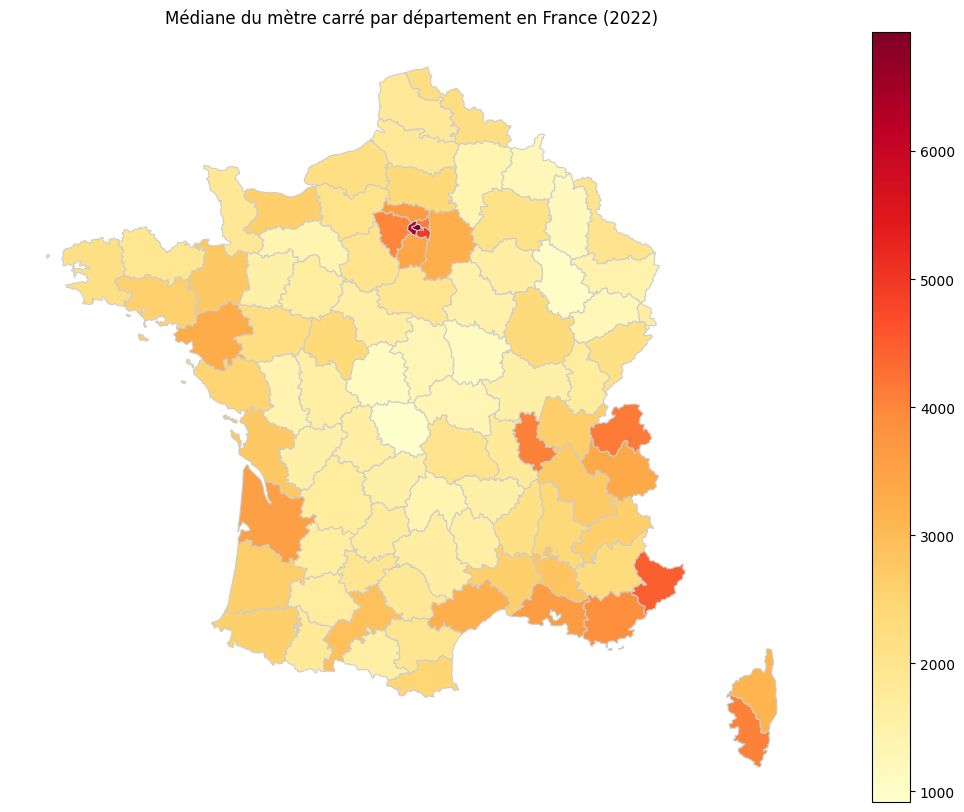

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='prix_au_metre_carre', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Médiane du mètre carré par département en France (2022)')
ax.set_axis_off()
plt.show()

Nous avons donc vu qu'il y a un lien important entre la localisation de l'habitation et son prix. Plus particulièrement, nous observons que la région Ile de France semble être beaucoup plus chère. C'est pourquoi, nous avons décidé de réaliser d'autres statistiques sur l'Ile de France uniquement.

## 3.1.2 Statistiques sur l'Ile de France

On restreint le data frame à l'Ile de France.

In [31]:
departements_idf = ['75', '77', '78', '91', '92', '93', '94', '95']
df_idf = df[df['code_departement'].astype(str).isin(departements_idf)]


In [32]:
df_idf['valeur_fonciere'].describe()

count    1.341040e+05
mean     3.150666e+05
std      2.105252e+05
min      1.500000e-01
25%      1.800000e+05
50%      2.700000e+05
75%      3.900000e+05
max      8.403500e+06
Name: valeur_fonciere, dtype: float64

In [33]:
df_idf['prix_au_metre_carre'].describe()

count    134104.000000
mean       4329.283579
std        1816.933402
min           0.001010
25%        3037.688679
50%        4011.123737
75%        5533.190476
max        8468.750000
Name: prix_au_metre_carre, dtype: float64

In [34]:
df['prix_au_metre_carre'].describe()

count    1.186464e+06
mean     2.873726e+03
std      1.712885e+03
min      1.010101e-03
25%      1.621333e+03
50%      2.500000e+03
75%      3.791149e+03
max      8.468750e+03
Name: prix_au_metre_carre, dtype: float64

On remarque que le prix moyen d'un bien immobilier en Ile de France est de 315 066€, contre 231 113 € pour la moyenne française, soit presque 85 000€ d'écart. On pourrait croire à une différence dans la superficie des biens, mais c'est bien le prix au mètre carré qui diffère totalement, avec une moyenne de 4329€/m² en Ile de France et 2873€/m² sur la France entière.

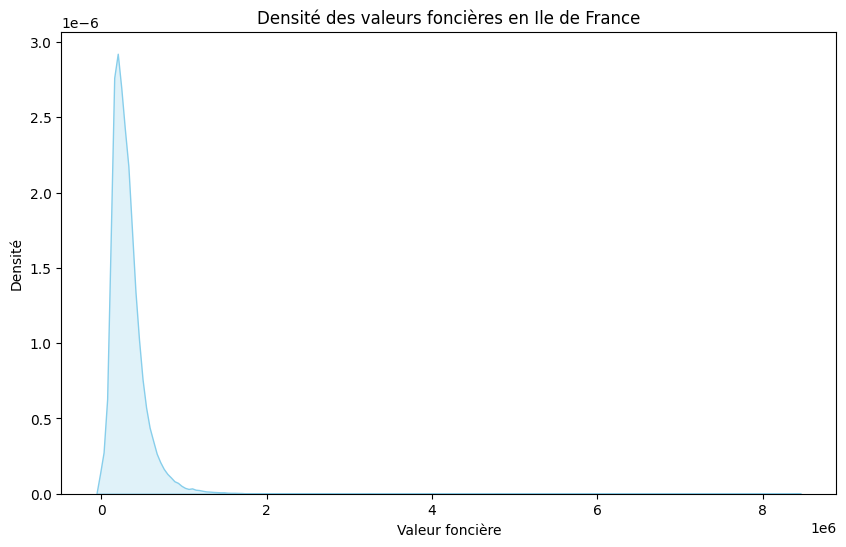

In [35]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_idf['valeur_fonciere'], fill=True, color='skyblue')
plt.xlabel('Valeur foncière')
plt.ylabel('Densité')
plt.title('Densité des valeurs foncières en Ile de France')
plt.show()

In [36]:
len(df_idf.loc[df_idf['valeur_fonciere']<510000])/len(df_idf) * 100

87.59395692895066

On remarque que cette fois-ci, le seuil défini plus haut (de 87.6%) est atteint avec une valeur_fonciere de 510 000€, soit 110 000€ de plus que dans la France entière.

Ainsi, avec ces premières statistiques, nous savons que la localisation est un facteur corrélé avec la valeur foncière d'un bien.

#**4. Corrélation entre les variables**

##4.1 Variables quantitatives

La base de données sur les valeurs foncières est composée des variables suivantes. Nous souhaiterions avoir davantage de variables quantitatives pour pouvoir trouver des corrélations numériques. Pour cela, nous devons transformer le type de certaines variables et également en créer d'autres.

In [37]:
df.dtypes

id_mutation                   object
date_mutation                 object
nature_mutation               object
valeur_fonciere              float64
adresse_nom_voie              object
code_commune                  object
nom_commune                   object
code_departement              object
ancien_code_commune          float64
ancien_nom_commune            object
nombre_lots                    int64
type_local                    object
surface_reelle_bati          float64
nombre_pieces_principales    float64
surface_terrain              float64
longitude                    float64
latitude                     float64
prix_au_metre_carre          float64
dtype: object

In [38]:
df['code_departement'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80',
       '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91',
       '92', '93', '94', '95', '971', '972', '973', '974', '75'],
      dtype=object)

Pour commencer, il s'agit de transformer le code_departement en un entier pour qu'il soit une variable quantitative. Cependant, nous rencontrons un problème avec la Corse et ses départements 2A et 2B. Nous décidons alors de les retirer du data frame, ainsi que les départements d'outre mer, car ils ne représentent que 19 000 données sur plus d'un million.

In [39]:
count_departments = df['code_departement'].isin(['971', '972', '973', '974','2A','2B']).sum()
count_total = len(df)
print(count_departments, count_total)

18994 1186464


In [40]:
df = df[~df['code_departement'].isin(['971', '972', '973', '974','2A','2B'])]
df['code_departement'] = df['code_departement'].astype(int)
df['code_commune'] = df['code_commune'].astype(int)

Ensuite, on ajoute le mois de vente à partir de la colonne date_mutation pour ensuite voir si elle a un impact sur la valeur foncière.

In [41]:
df['mois_vente'] = df['date_mutation'].str[-2:]
df['mois_vente'] = df['mois_vente'].astype(int)

Ensuite, on ne garde que les variables quantitatives.

In [42]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num = df_num.drop('ancien_code_commune', axis=1)
df_num.head()

,valeur_fonciere,code_commune,code_departement,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre,mois_vente
0,55000.0,1053,1,1,24.0,1.0,NaN,5.218712,46.198053,2291.666667,3
3,143000.0,1398,1,1,140.0,3.0,NaN,4.848340,46.000631,1021.428571,3
5,255000.0,1230,1,0,108.0,5.0,649.0,5.103407,46.422348,2361.111111,6
8,525000.0,1333,1,0,126.0,4.0,628.0,4.951266,45.926511,4166.666667,3
12,64000.0,1053,1,1,117.0,2.0,NaN,5.229155,46.204984,547.008547,5


<Axes: >

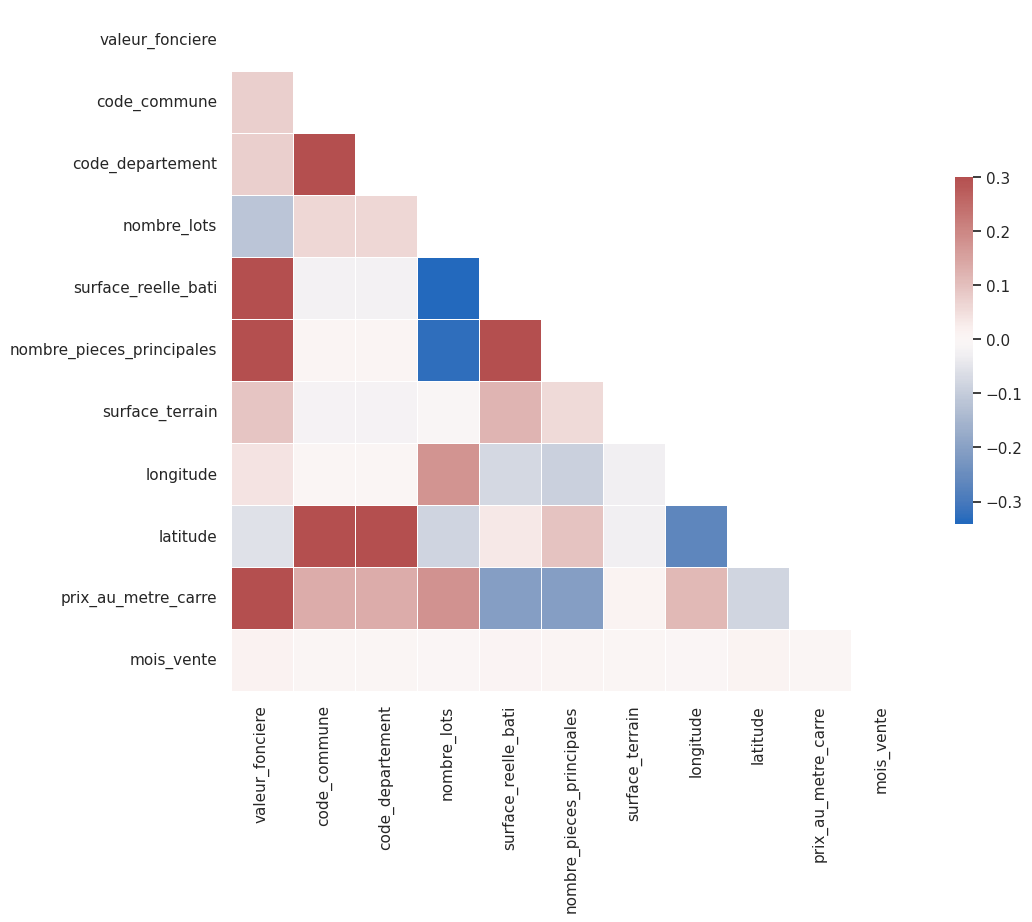

In [43]:
sns.set_theme(style="white")
corr = df_num.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("vlag", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Cherchons les variables numériques les plus corrélées au prix et classons-les. Les variables les plus corrélées au prix sont alors le prix au mètre carré, la surface réelle du batiment ainsi que le nombre de pièces.

In [44]:
var_quanti_corr = df_num.corr()['valeur_fonciere']
var_plus_corr = var_quanti_corr.sort_values(ascending=False)
print(var_plus_corr)

valeur_fonciere              1.000000
prix_au_metre_carre          0.577723
surface_reelle_bati          0.547481
nombre_pieces_principales    0.423261
surface_terrain              0.089922
code_departement             0.076462
code_commune                 0.076216
longitude                    0.041401
mois_vente                   0.012217
latitude                    -0.056534
nombre_lots                 -0.116769
Name: valeur_fonciere, dtype: float64


##4.2 Variables qualitatives

###4.2.1 La variable type_local

Nous souhaitons également connaitre la corrélation entre la valeur foncière d'un bien et certaines variables qualitatives, comme le type de bien (Appartement, Maison). Pour ce faire, nous avons utilisé la corrélaion de Spearman, qui permet d'évaluer la relation monotone entre deux variables, l'une quantitative et l'autre qualitative, ici valeur_fonciere et type_local. Elle donne une mesure de la force et de la direction de la relation entre les deux variables. Ici, le coefficient de corrélation est 0.18 et est positif, ce qui suggère qu'une augmentation de la valeur foncière est conjointement lié à une augmentation du type de local, d'appartement vers maison.

In [45]:
correlation_coefficient, p_value = spearmanr(df['valeur_fonciere'], df['type_local'])
print(f"Corrélation de Spearman : {correlation_coefficient}")
print(f"P-valeur : {p_value}")

Corrélation de Spearman : 0.175415067663928
P-valeur : 0.0


In [46]:
valeurs_non_numeriques = pd.to_numeric(df['valeur_fonciere'], errors='coerce').isnull()
df[valeurs_non_numeriques]['valeur_fonciere']

Series([], Name: valeur_fonciere, dtype: float64)

De plus, nous effectuons un t test pour comparer les moyennes des deux groupes, Maison et Appartement.  

In [47]:
maison = df[df['type_local'] == 'Maison']['valeur_fonciere']
appartement = df[df['type_local'] == 'Appartement']['valeur_fonciere']

t_statistic, p_value_t = ttest_ind(maison, appartement)

print(f"Test t - Statistique t : {t_statistic}, p-valeur : {p_value_t}")

Test t - Statistique t : 186.41453305698334, p-valeur : 0.0


La t-statistique mesure la différence entre les moyennes des deux groupes standardisée par l'erreur standard. Alors, une valeur de 186 indique une différence très importante entre les moyennes. De plus, la p-valeur est la probabilité d'observer une statistique t aussi extrême (ou plus) si l'hypothèse nulle était vraie (c'est-à-dire si les moyennes réelles des groupes étaient égales). La p-valeur étant de 0, et donc inférieure à 0.05, cela signifie que la probabilité d'observer une telle différence par hasard est pratiquement nulle.



**Pour conclure, ces résultats suggèrent fortement que les moyennes des groupes "Maison" et "Appartement" sont significativement différentes l'une de l'autre pour la variable valeur_fonciere.**

###4.2.2 La variable type_voie

Nous ne disposons pas directement du type de voie dans lequel le bien immobilier se situe, c'est pourquoi nous allons devoir extraire cette information des autres colonnes.

In [48]:
df.head()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre,mois_vente
0,2022-1,2022-01-03,Vente,55000.0,RUE DE LA LIBERTE,1053,Bourg-en-Bresse,1,NaN,NaN,1,Appartement,24.0,1.0,NaN,5.218712,46.198053,2291.666667,3
3,2022-2,2022-01-03,Vente,143000.0,RTE DE LA DOMBES,1398,Savigneux,1,NaN,NaN,1,Appartement,140.0,3.0,NaN,4.848340,46.000631,1021.428571,3
5,2022-4,2022-01-06,Vente,255000.0,RTE DE POISATON,1230,Mantenay-Montlin,1,NaN,NaN,0,Maison,108.0,5.0,649.0,5.103407,46.422348,2361.111111,6
8,2022-5,2022-01-03,Vente,525000.0,PL DE LA CROIX BLANCHE,1333,Saint-André-de-Corcy,1,NaN,NaN,0,Appartement,126.0,4.0,628.0,4.951266,45.926511,4166.666667,3
12,2022-7,2022-01-05,Vente,64000.0,BD DE BROU,1053,Bourg-en-Bresse,1,NaN,NaN,1,Appartement,117.0,2.0,NaN,5.229155,46.204984,547.008547,5


Pour cela, nous prenons le premier mot de la colonne adresse_nom_voie et on ne garde que les lignes qui correspondent à des rues, avenues, boulevards, chemins, routes, places, allées ou impasses. Les autres types sont souvent des lieux dits, sans adresse précise. En réduisant ce dataframe, on reste tout de même à presque un million de données.

In [49]:
df['type_voie'] = df['adresse_nom_voie'].str.split().str[0]

In [50]:
df_voie = df[df['type_voie'].isin(['RUE', 'AV', 'BD', 'CHE', 'RTE', 'PL', 'ALL', 'IMP'])]

In [51]:
df_voie.shape[0]

961433

On renomme les types de voies.

In [ ]:
mapping_types_voie = {'RUE': 'Rue', 'RTE': 'Route', 'PL': 'Place', 'AV': 'Avenue', 'BD': 'Boulevard', 'CHE': 'Chemin', 'ALL': 'Allée', 'IMP': 'Impasse'}
df_voie['type_voie'] = df_voie['type_voie'].replace(mapping_types_voie)

In [ ]:
df_voie.head()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre,mois_vente,type_voie
0,2022-1,2022-01-03,Vente,55000.0,RUE DE LA LIBERTE,1053,Bourg-en-Bresse,1,NaN,NaN,1,Appartement,24.0,1.0,NaN,5.218712,46.198053,2291.666667,3,Rue
3,2022-2,2022-01-03,Vente,143000.0,RTE DE LA DOMBES,1398,Savigneux,1,NaN,NaN,1,Appartement,140.0,3.0,NaN,4.848340,46.000631,1021.428571,3,Route
5,2022-4,2022-01-06,Vente,255000.0,RTE DE POISATON,1230,Mantenay-Montlin,1,NaN,NaN,0,Maison,108.0,5.0,649.0,5.103407,46.422348,2361.111111,6,Route
8,2022-5,2022-01-03,Vente,525000.0,PL DE LA CROIX BLANCHE,1333,Saint-André-de-Corcy,1,NaN,NaN,0,Appartement,126.0,4.0,628.0,4.951266,45.926511,4166.666667,3,Place
12,2022-7,2022-01-05,Vente,64000.0,BD DE BROU,1053,Bourg-en-Bresse,1,NaN,NaN,1,Appartement,117.0,2.0,NaN,5.229155,46.204984,547.008547,5,Boulevard


Simplement avec ces boîtes à moustaches, on peut constater que les médianes des valeurs foncières entre les différents types de voies diffèrent très largement. Cependant, nous souhaitons en extraire un coefficient de corrélation pour savoir si le type de voie est corrélé au prix.

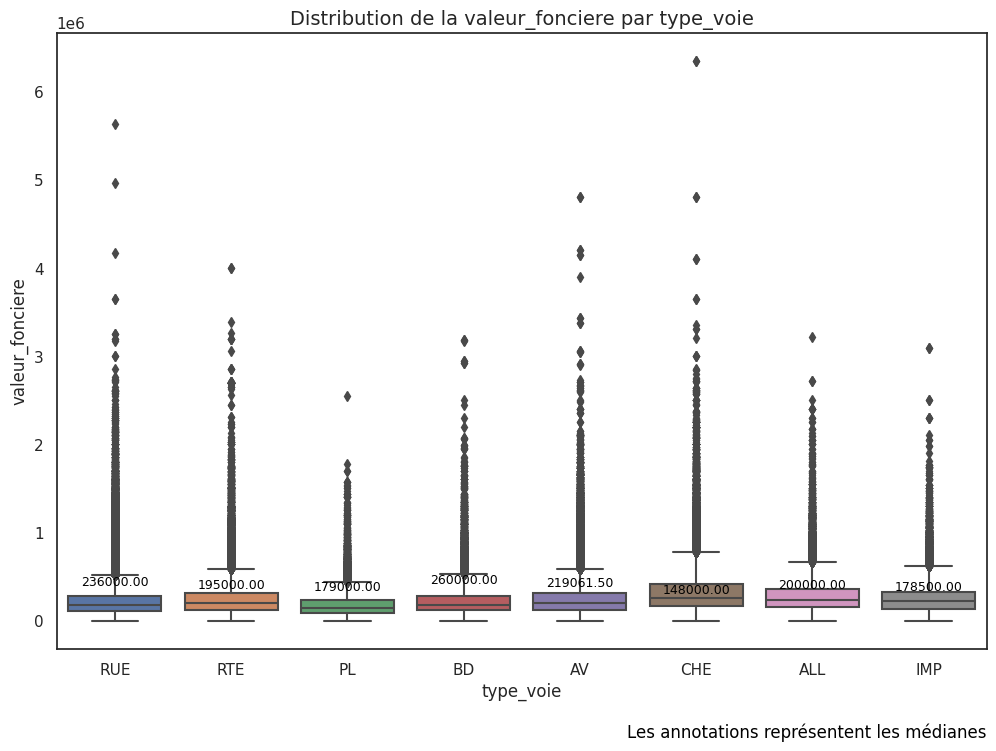

In [52]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='type_voie', y='valeur_fonciere', data=df_voie)

medians = df_voie.groupby('type_voie')['valeur_fonciere'].median()
medians_dict = medians.to_dict()

for cat, median_value in medians_dict.items():
    ax.text(list(medians.index).index(cat),
            median_value + ax.get_ylim()[1]*0.02,
            f'{median_value:.2f}',
            ha='center', va='bottom', color='black', fontsize=9)

ax.text(1, -0.15, 'Les annotations représentent les médianes', ha='right', va='bottom', color='black', fontsize=12, transform=ax.transAxes)

plt.title('Distribution de la valeur_fonciere par type_voie', fontsize=14)
plt.show()

Nous nous sommes heurtés à de nombreux problèmes quant au coefficient de corrélation entre les variables valeur_fonciere, quantitative, et type_voie, elle qualitative, car contrairement à type_local, la variable n'est pas binaire et comporte 8 niveaux. Après avoir étudié les méthodes ANOVA juste en dessous, qui ne testait que la variation des moyennes entre plusieurs groupes, nous nous sommes penchés sur l'Analyse de Corrélation Canonique (CCA), qui nous a permis de tirer un coefficient de corrélation. En effet, la CCA est une méthode puissante pour évaluer les relations linéaires complexes entre des ensembles de variables multiples.

ANOVA (Analysis of Variance) : permet de comparer les moyennes de trois groupes ou plus afin de déterminer s'il existe des différences significatives entre eux

In [53]:
resultats_anova = f_oneway(*[df_voie['valeur_fonciere'][df_voie['type_voie'] == cat] for cat in df_voie['type_voie'].unique()])

print("Statistique F :", resultats_anova.statistic)
print("P-valeur :", resultats_anova.pvalue)

Statistique F : 4189.93154810312
P-valeur : 0.0


La statistique F étant de 4190, cela indique une grande variation entre les groupes par rapport à la variation à l'intérieur des groupes. La p-value de 0 suggère qu'il faut rejeter l'hypothèses nulle et ainsi, les moyennes des groupes ne sont pas égales. Cependant, cela ne nous donne pas le coefficient de corrélation. Passons donc à la méthode CCA. On crée un dataframe one_hot_encoded où chaque catégorie unique présente dans la colonne "type_voie" devient une nouvelle colonne binaire. Chaque colonne binaire indique la présence ou l'absence de la catégorie respective pour chaque ligne du dataframe original.

In [54]:
df_voie['type_voie'] = df_voie['type_voie'].astype('category')

# Création d'un encodage one-hot pour la variable qualitative
one_hot_encoded = pd.get_dummies(df_voie['type_voie'], prefix='voie')

df_combined = pd.concat([df_voie['valeur_fonciere'], one_hot_encoded], axis=1)

# Séparation des variables en x et y
X = df_combined.drop('valeur_fonciere', axis=1)
y = df_combined['valeur_fonciere']

# Analyse de corrélation canonique (CCA)
cca = CCA(n_components=1)
cca.fit(X, y)

cca_transformed = cca.transform(X, y)
cca_coefficients = cca_transformed[0]

print("Coefficient de corrélation canonique:", cca_coefficients[0][0])

Coefficient de corrélation canonique: -0.6140106666399985


La première composante canonique est une nouvelle variable (ou axe) qui est créée à partir des variables originales de manière à capturer le maximum de la corrélation entre les deux ensembles X et Y. Cette composante canonique est une expression mathématique définie par des coefficients (poids) attribués à chaque variable dans les ensembles X et Y. Ainsi, -0,61 indique la force et la direction de la corrélation maximale entre la première composante canonique et valeur_fonciere.

In [55]:
df_combined.head()

,valeur_fonciere,voie_ALL,voie_AV,voie_BD,voie_CHE,voie_IMP,voie_PL,voie_RTE,voie_RUE
0,55000.0,0,0,0,0,0,0,0,1
3,143000.0,0,0,0,0,0,0,1,0
5,255000.0,0,0,0,0,0,0,1,0
8,525000.0,0,0,0,0,0,1,0,0
12,64000.0,0,0,1,0,0,0,0,0


Alors, lorsqu'on observe une transition d'une catégorie à une autre dans la variable catégorielle "type_voie", on s'attend à une variation dans les valeurs de "valeur_fonciere" en fonction du coefficient de corrélation canonique.

In [56]:
df_voie = df_voie.dropna(subset=['type_voie', 'valeur_fonciere'])

# **5. Réduction de l'analyse à Paris pour l'ajout de variables explicatives**

##5.1 Ajout de la variable de distance à une station de métro ou RER

On s'intéresse maintenant à Paris intramuros pour essayer de prédire les prix. Pour cela, nous choisissons de voir si la proximité d'une station de métro ou RER est liée à la valeur foncière. Pour cela, nous importons les données des gares depuis data.gouv.fr et nous en créons un dataframe.

In [57]:
df_stations= pd.read_csv('emplacement-des-gares-idf.csv', sep=';',low_memory=False)
df_stations.head(5)

,geo_point_2d,geo_shape,id_gares,nom_gares,nom_so_gar,nom_su_gar,id_ref_zdc,nom_zdc,id_ref_zda,nom_zda,...,termetro,tertram,terval,exploitant,idf,principal,x,y,picto,nom_iv
0,"48.96375542868628,2.372103138402568","{""coordinates"": [2.372103138402568, 48.9637554...",643,Pierrefitte Stains,NaN,NaN,72787,Pierrefitte - Stains,43179,Pierrefitte - Stains,...,0,0,0,SNCF,1,0,654024.0938,6.873939e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Pierrefitte Stains
1,"48.78031379546215,2.312307716888593","{""coordinates"": [2.312307716888593, 48.7803137...",102,Bourg-la-Reine,NaN,NaN,70033,Bourg-la-Reine,43097,Bourg-la-Reine,...,0,0,0,RATP,1,0,649468.2085,6.853578e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Bourg-la-Reine
2,"48.43449061192662,2.376672818506991","{""coordinates"": [2.376672818506991, 48.4344906...",106,Boutigny,NaN,NaN,59565,Boutigny,47895,Boutigny,...,0,0,0,SNCF,1,0,653894.1827,6.815094e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Boutigny
3,"48.97066504738864,2.0777317645655975","{""coordinates"": [2.077731764565597, 48.9706650...",7,Achères-Ville,NaN,NaN,73604,Achères Ville,46647,Achères Ville,...,0,0,0,SNCF,1,0,632479.4115,6.874919e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Achères-Ville
4,"48.31129627381493,2.0035250000979885","{""coordinates"": [2.003525000097989, 48.3112962...",18,Angerville,NaN,NaN,59403,Angerville,47917,Angerville,...,0,0,0,SNCF,1,0,626121.8463,6.801685e+06,NaN,Angerville


In [58]:
df_stations=df_stations.drop(['id_gares','nom_so_gar',
       'nom_su_gar','id_ref_zdc','nom_zdc', 'id_ref_zda', 'nom_zda','idrefliga', 'idrefligc','tertrain',
       'terrer', 'termetro', 'tertram', 'terval', 'exploitant','idf',
       'principal','picto', 'nom_iv','x','y'],axis=1)

In [59]:
df_idf

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre
3506704,2022-1240169,2022-01-03,Vente,369900.0,RUE GUSTAVE COURBET,77053,Brie-Comte-Robert,77,NaN,NaN,0,Maison,77.0,4.0,720.0,2.623259,48.689175,4803.896104
3506710,2022-1240174,2022-01-06,Vente,727530.0,RUE GUERIN,77186,Fontainebleau,77,NaN,NaN,0,Maison,150.0,8.0,181.0,2.696749,48.406800,4850.200000
3506712,2022-1240175,2022-01-07,Vente,355000.0,AV P VAILLANT COUTURIER,77152,Dammarie-les-Lys,77,NaN,NaN,0,Maison,136.0,4.0,500.0,2.612142,48.509430,2610.294118
3506713,2022-1240175,2022-01-07,Vente,355000.0,AV P VAILLANT COUTURIER,77152,Dammarie-les-Lys,77,NaN,NaN,0,Maison,136.0,4.0,662.0,2.612142,48.509430,2610.294118
3506715,2022-1240176,2022-01-07,Vente,173000.0,ALL DE LA FRATERNITE,77296,Moissy-Cramayel,77,NaN,NaN,1,Appartement,61.0,3.0,NaN,2.588543,48.628815,2836.065574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617567,2022-1668739,2022-03-10,Vente,119820.0,RUE CHANEZ,75116,Paris 16e Arrondissement,75,NaN,NaN,0,Appartement,47.0,3.0,2323.0,2.260591,48.847425,2549.361702
4617568,2022-1668739,2022-03-10,Vente,119820.0,RUE CHANEZ,75116,Paris 16e Arrondissement,75,NaN,NaN,0,Appartement,39.0,1.0,2323.0,2.260591,48.847425,3072.307692
4617577,2022-1668744,2022-03-22,Vente,232650.0,AV D ITALIE,75113,Paris 13e Arrondissement,75,NaN,NaN,1,Appartement,29.0,1.0,NaN,2.359044,48.822516,8022.413793
4617578,2022-1668744,2022-03-22,Vente,232650.0,AV D ITALIE,75113,Paris 13e Arrondissement,75,NaN,NaN,1,Appartement,49.0,2.0,NaN,2.359044,48.822516,4747.959184


On veut calculer la distance à la gare la plus proche en Ile de France, donc on retire les lignes qui ont une latitude ou une longitude manquante.

In [60]:
df_idf = df_idf.dropna(subset=['latitude', 'longitude'])
df_stations = df_stations.dropna(subset=['geo_point_2d'])

Calculons la distance à la gare la plus proche. Vu le nombre de calcul à faire pour pouvoir avoir ces distances, le programme prend 1h20. Ce n'est pas un calcul que l'on va donc refaire à chaque fois. Par conséquent, on va sauvergarder ces informations sur un fichier annexe duquel on puisera l'information à chaque fois.

In [ ]:
#def find_nearest_station(apartment, stations_df):
#    apartment_coords = (apartment['latitude'], apartment['longitude'])
#    distances = stations_df.apply(lambda row: geodesic(apartment_coords, row['geo_point_2d']).meters, axis=1)
#    nearest_station_index = distances.idxmin()
#    nearest_station = stations_df.loc[nearest_station_index, 'nom_gares']
#    return (nearest_station,distances[nearest_station_index])
#df_idf['nearest_station'] = df_idf.apply(lambda row: find_nearest_station(row,stations_echantillonneesdf_stations),axis=1)
#df_idf[['nom_station','distance_station_plus_proche']]=df_idf['nearest_station'].apply(lambda x: pd.Series(x))
#df_idf.head()df_gares_proches=df_idf.drop(columns=[ 'date_mutation', 'numero_disposition', 'nature_mutation','valeur_fonciere', 'adresse_numero', 'adresse_suffixe','adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune','nom_commune', 'code_departement', 'ancien_code_commune','ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle','numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero','lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez','lot4_numero', 'lot4_surface_carrez', 'lot5_numero','lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local','surface_reelle_bati', 'nombre_pieces_principales','code_nature_culture', 'nature_culture', 'code_nature_culture_speciale','nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude','prix_au_metre_carre', 'nearest_station', ],axis=1)
#df_gares_proches.to_csv('/content/drive/MyDrive/2A_Python pour la data science/stations_les_plus_proches.txt',index=False)

Maintenant, on va faire un code pour récupérer cette information beaucoup plus rapidement, grâce au fichier.

In [ ]:
#path = '/content/drive/MyDrive/2A_Python pour la data science/'
#df_gares_proches= pd.read_csv(path+'stations_les_plus_proches.txt', sep=',',low_memory=False)
#df_idf=pd.merge(df_idf,df_gares_proches, on='id_mutation', how='inner')
#df_idf=df_idf.drop_duplicates()
#df_idf.head(5)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre,nom_station,distance_station_plus_proche
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,NaN,NaN,2,Appartement,36.0,2.0,NaN,2.386648,48.869335,6111.111111,Ménilmontant,391.401920
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,NaN,NaN,2,Appartement,27.0,2.0,NaN,2.375845,48.891167,7407.407407,Crimée,95.815818
2,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,NaN,NaN,2,Appartement,52.0,2.0,NaN,2.408031,48.873089,8190.192308,Adrienne Bolland,118.475928
3,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,NaN,NaN,1,Appartement,81.0,3.0,NaN,2.352517,48.895742,8148.148148,Diane Arbus,293.697106
4,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,NaN,NaN,1,Appartement,30.0,2.0,NaN,2.322935,48.887298,493.333333,La Fourche,209.004643


On réduit ce data frame à Paris ce qui nous donne 6663 données.

In [61]:
df_paris = df_idf[df_idf['code_departement'] == '75']
df_paris

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_au_metre_carre
4519635,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,NaN,NaN,2,Appartement,36.0,2.0,NaN,2.386648,48.869335,6111.111111
4519638,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,NaN,NaN,2,Appartement,27.0,2.0,NaN,2.375845,48.891167,7407.407407
4519646,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,NaN,NaN,2,Appartement,52.0,2.0,NaN,2.408031,48.873089,8190.192308
4519648,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,NaN,NaN,1,Appartement,81.0,3.0,NaN,2.352517,48.895742,8148.148148
4519660,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,NaN,NaN,1,Appartement,30.0,2.0,NaN,2.322935,48.887298,493.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617567,2022-1668739,2022-03-10,Vente,119820.0,RUE CHANEZ,75116,Paris 16e Arrondissement,75,NaN,NaN,0,Appartement,47.0,3.0,2323.0,2.260591,48.847425,2549.361702
4617568,2022-1668739,2022-03-10,Vente,119820.0,RUE CHANEZ,75116,Paris 16e Arrondissement,75,NaN,NaN,0,Appartement,39.0,1.0,2323.0,2.260591,48.847425,3072.307692
4617577,2022-1668744,2022-03-22,Vente,232650.0,AV D ITALIE,75113,Paris 13e Arrondissement,75,NaN,NaN,1,Appartement,29.0,1.0,NaN,2.359044,48.822516,8022.413793
4617578,2022-1668744,2022-03-22,Vente,232650.0,AV D ITALIE,75113,Paris 13e Arrondissement,75,NaN,NaN,1,Appartement,49.0,2.0,NaN,2.359044,48.822516,4747.959184


On crée une colonne avec l'arrondissement et on retire d'autres colonnes inutiles.

In [62]:
df_paris['arrondissement'] = df_paris['code_commune'].astype(str).str[-2:]

In [63]:
df_paris = df_paris.drop(columns=["ancien_code_commune", "ancien_nom_commune", "surface_terrain"], errors='ignore')

In [64]:
df_paris.head(5)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_metre_carre,arrondissement
4519635,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,36.0,2.0,2.386648,48.869335,6111.111111,20
4519638,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,27.0,2.0,2.375845,48.891167,7407.407407,19
4519646,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,2,Appartement,52.0,2.0,2.408031,48.873089,8190.192308,20
4519648,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,1,Appartement,81.0,3.0,2.352517,48.895742,8148.148148,18
4519660,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,1,Appartement,30.0,2.0,2.322935,48.887298,493.333333,17


In [ ]:
#def find_nearest_station(apartment, stations_df):
#    apartment_coords = (apartment['latitude'], apartment['longitude'])
#    distances = stations_df.apply(lambda row: geodesic(apartment_coords, row['geo_point_2d']).meters, axis=1)
#    nearest_station_index = distances.idxmin()
#    nearest_station = stations_df.loc[nearest_station_index, 'nom_gares']
#    return (nearest_station,distances[nearest_station_index])
#df_paris['nearest_station'] = df_paris.apply(lambda row: find_nearest_station(row,df_stations),axis=1)
#df_paris[['nom_station','distance_station_plus_proche']]=df_paris['nearest_station'].apply(lambda x: pd.Series(x))
#df_paris.head()

#df_gares_proches_paris=df_paris.drop(columns=[ 'date_mutation', 'nature_mutation', 'valeur_fonciere','adresse_nom_voie', 'code_commune', 'nom_commune', 'code_departement','ancien_code_commune', 'ancien_nom_commune', 'nombre_lots','type_local', 'surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'longitude', 'latitude', 'prix_au_metre_carre','nearest_station',],axis=1)
#df_gares_proches_paris.to_csv('/content/drive/MyDrive/2A_Python pour la data science/stations_les_plus_proches.txt',index=False)

In [65]:
df_gares_proches= pd.read_csv('stations_les_plus_proches.txt', sep=',',low_memory=False)
df_paris=pd.merge(df_paris,df_gares_proches, on='id_mutation', how='inner')
df_paris=df_paris.drop_duplicates()
df_paris.head(5)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_metre_carre,arrondissement,nom_station,distance_station_plus_proche
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,36.0,2.0,2.386648,48.869335,6111.111111,20,Ménilmontant,391.401920
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,27.0,2.0,2.375845,48.891167,7407.407407,19,Crimée,95.815818
2,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,2,Appartement,52.0,2.0,2.408031,48.873089,8190.192308,20,Adrienne Bolland,118.475928
3,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,1,Appartement,81.0,3.0,2.352517,48.895742,8148.148148,18,Diane Arbus,293.697106
4,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,1,Appartement,30.0,2.0,2.322935,48.887298,493.333333,17,La Fourche,209.004643


On a donc rajouté une variable explicative : la distance à la gare la plus proche.

##5.2 Ajout de la distance à un espace vert

On a voulu se restreindre à Paris dans cette partie car nous ne possédons que les espaces verts de Paris. On importe les données depuis data.gouv.fr et on garde uniquement les espaces verts de tailles conséquente, c'est à dire les promenades et les bois.

In [66]:
df_espaces_verts=pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/df83af76-2045-4b3e-8a94-b7cced0d0b69',sep=';',low_memory=False)
df_espaces_verts=df_espaces_verts.drop(['nsq_espace_vert',
       'surface_horticole', 'presence_cloture', 'perimeter', 'annee_ouverture',
       'annee_renovation', 'ancien_nom_ev', 'annee_changement_nom',
       'nb_entites', 'ouvert_ferme',  'id_atelier_horticole','geom_x_y','competence','id_eqpt','site_villes','ida3d_enb',
       ],axis=1)
df_espaces_verts['type_ev'].unique()

array(['Promenades ouvertes', 'Décorations sur la voie publique',
       'Jardinets décoratifs', 'Périphérique', 'Murs végétalisés',
       'Cimetières', 'Ephémères, partagés, pédagogiques',
       'Etablissements sportifs', nan, 'Bois', 'Jardins privatifs'],
      dtype=object)

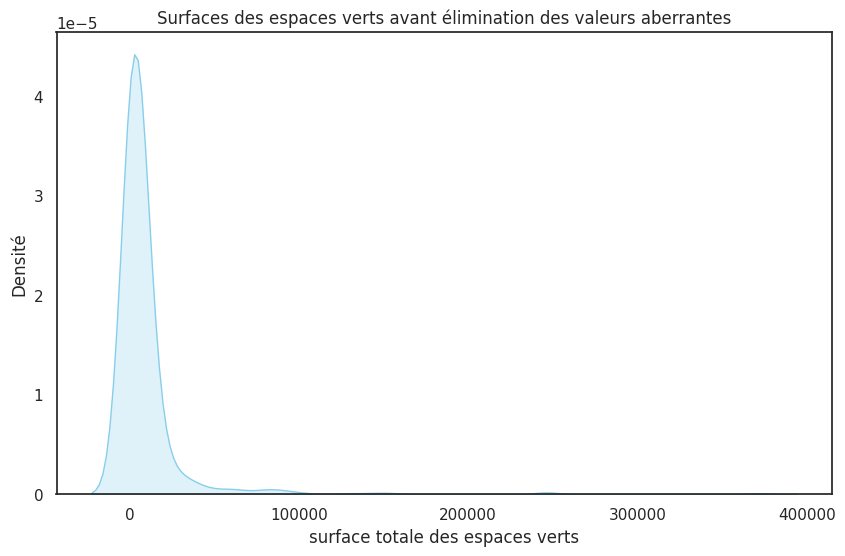

In [67]:
df_espaces_verts=df_espaces_verts[df_espaces_verts['type_ev'].isin(['Promenades ouvertes', 'Bois'])]

plt.figure(figsize=(10, 6))
sns.kdeplot(df_espaces_verts['surface_totale_reelle'], fill=True, color='skyblue')
plt.xlabel('surface totale des espaces verts')
plt.ylabel('Densité')
plt.title('Surfaces des espaces verts avant élimination des valeurs aberrantes')
plt.show()

df_espaces_verts=df_espaces_verts[df_espaces_verts['surface_totale_reelle']>=130]


In [68]:
df_espaces_verts=df_espaces_verts[df_espaces_verts['type_ev'].isin(['Promenades ouvertes', 'Bois'])]

df_espaces_verts=df_espaces_verts[df_espaces_verts['surface_totale_reelle']>=130]
df_espaces_verts['surface_totale_reelle'].describe()

count       565.000000
mean       9443.684956
std       26490.045424
min         130.000000
25%        1450.000000
50%        3300.000000
75%        6894.000000
max      371602.000000
Name: surface_totale_reelle, dtype: float64

In [69]:
df_espaces_verts['categorie'].unique()

array(['Square', 'Promenade', 'Jardin', "Jardin d'immeubles", 'Parc',
       'square', 'Esplanade', 'Mail', 'Pelouse', 'Plate-bande',
       'Jardiniere', 'Terrain de boules', 'Espace Vert', 'Jardinet',
       'Archipel', 'Ile'], dtype=object)

In [70]:
df_espaces_verts.nsmallest(5, 'poly_area')

,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,surface_totale_reelle,id_division,geom,url_plan
1636,JARDINET MADELEINE DE SCUDERY,Promenades ouvertes,Jardinet,3.0,NaN,RUE DES,OISEAUX,75003.0,127.0,130.0,101.0,"{""coordinates"": [[[2.3616152707656863, 48.8631...",http://p70-planet.apps.paris.mdp/Advitium/Appe...
1758,SQUARE DAUMESNIL,Promenades ouvertes,Square,29.0,NaN,ROUTE DE,CEINTURE DU LAC DAUMESNIL,75012.0,147.0,147.0,7.0,"{""coordinates"": [[[2.4137959885236637, 48.8329...",http://p70-planet.apps.paris.mdp/Advitium/Appe...
2125,SQUARE EMMI PIKLER,Promenades ouvertes,Square,3.0,NaN,RUE,OLIVIER METRA,75020.0,194.0,157.0,120.0,"{""coordinates"": [[[2.3953659209960625, 48.8715...",http://p70-planet.apps.paris.mdp/Advitium/Appe...
2198,JARDIN DE L EGLISE SAINT GERMAIN DE CHARONNE,Promenades ouvertes,Jardin,4.0,B,PLACE,SAINT-BLAISE,75020.0,197.0,192.0,120.0,"{""coordinates"": [[[2.4038487271813667, 48.8603...",http://p70-planet.apps.paris.mdp/Advitium/Appe...
1977,JARDIN DE LA RUE DU SIMPLON (JARDIN D'ENFANTS),Promenades ouvertes,Jardin,36.0,NaN,RUE DU,SIMPLON,75018.0,204.0,291.0,118.0,"{""coordinates"": [[[2.3496467136039936, 48.8940...",http://p70-planet.apps.paris.mdp/Advitium/Appe...


Malgré notre premier tri sur les promenades et bois, il reste des espaces verts trop petits pour en être réellement. On décide donc de retirer les espaces verts qui ne font pas plus de 130m².

In [71]:
df_espaces_verts = df_espaces_verts.loc[df_espaces_verts['surface_totale_reelle'] > 130]


Pour commencer, nous décidons d'afficher une carte pour voir si la répartition des espaces verts est équilibrée ou pas. Pour cela, on importe un geojson sur les arrondissements et on affiche une carte avec le nombre d'espaces verts par arrondissement.

In [72]:
url_arrondissements='https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c'
arrondissements_geojson=gpd.read_file(url_arrondissements)

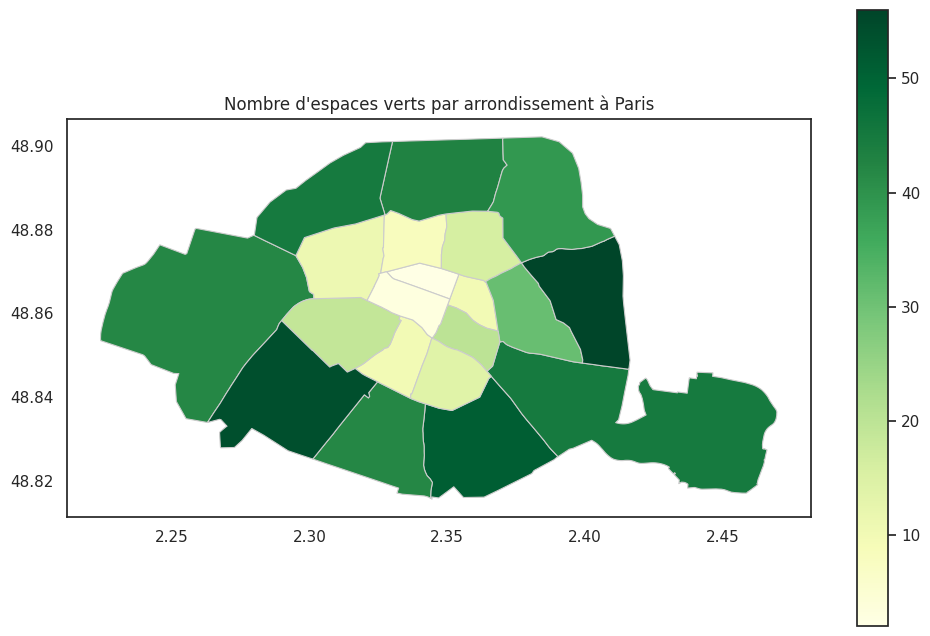

In [73]:
df_espaces_verts['adresse_codepostal'] = df_espaces_verts['adresse_codepostal'].astype(int)
df_espaces_verts['arrondissement'] = df_espaces_verts['adresse_codepostal'].apply(lambda x: int(str(x)[2:]))

df_grouped = df_espaces_verts.groupby('arrondissement').size().reset_index(name='nombre_espaces_verts')
new_df_merged = arrondissements_geojson.merge(df_grouped, left_on='c_ar', right_on='arrondissement')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_df_merged.plot(column='nombre_espaces_verts', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Nombre d\'espaces verts par arrondissement à Paris')
plt.show()

Alors, on voit que les espaces verts sont principalement situés dans les arrondissements extérieurs. Maintenant que nous savons que ce n'est pas forcément inintéressant, calculons la distance de chaque bien à l'espace vert le plus proche dans Paris.

On extrait les coordonnées du dictionnaire.

In [74]:
df_espaces_verts= df_espaces_verts.dropna(subset=['geom'])
df_espaces_verts['geom']=df_espaces_verts['geom'].astype(str)
df_espaces_verts['geom'] = df_espaces_verts['geom'].apply(json.loads)
df_espaces_verts['geom'] = df_espaces_verts['geom'].apply(lambda x: x['coordinates'])
df_espaces_verts.head(5)

,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,surface_totale_reelle,id_division,geom,url_plan,arrondissement
0,SQUARE SAMUEL ROUSSEAU,Promenades ouvertes,Square,28.0,B,RUE,LAS CASES,75007,1810.0,2047.0,101.0,"[[[2.3196458242480142, 48.85927238147114], [2....",http://p70-planet.apps.paris.mdp/Advitium/Appe...,7
1,COULEE VERTE RENE DUMONT - PROMENADE DES RUES ...,Promenades ouvertes,Promenade,82.0,BIS,RUE DE,PICPUS,75012,10427.0,8190.0,111.0,"[[[[2.398679031193932, 48.84114644477936], [2....",http://p70-planet.apps.paris.mdp/Advitium/Appe...,12
2,SQUARE JULES VERNE,Promenades ouvertes,Square,1.0,NaN,RUE,JULES VERNE,75011,2287.0,2300.0,111.0,"[[[2.375021664754788, 48.87064640766222], [2.3...",http://p70-planet.apps.paris.mdp/Advitium/Appe...,11
3,SQUARE DE L'ABBE LEMIRE,Promenades ouvertes,Square,78.0,NaN,RUE,VERCINGETORIX,75014,4566.0,3500.0,114.0,"[[[2.31527756541661, 48.835894396152646], [2.3...",http://p70-planet.apps.paris.mdp/Advitium/Appe...,14
4,JARDIN BERTHE MORISOT,Promenades ouvertes,Jardin,34.0,NaN,RUE DU,DESSOUS DES BERGES,75013,2963.0,2950.0,113.0,"[[[2.3750222700195183, 48.82638252373527], [2....",http://p70-planet.apps.paris.mdp/Advitium/Appe...,13


On extrait les premières coordonnées du polygone représentant l'espace vert.

In [75]:
def extract_first_element(coord_list):
    texte=str(coord_list)
    i=0
    while texte[i]=='[':
      i+=1
    liste=coord_list
    for i in range (i-1):
      liste=liste[0]
    return liste[0],liste[1]

df_espaces_verts['first_coordinate'] = df_espaces_verts['geom'].apply(extract_first_element)

In [76]:
df_paris.head(1)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_metre_carre,arrondissement,nom_station,distance_station_plus_proche
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,36.0,2.0,2.386648,48.869335,6111.111111,20,Ménilmontant,391.40192


Nous avons ensuite calculé la distance à l'espace vert le plus proche, mais comme le programme met 16 min pour tourner, nous avons enregistré les données qui procure et nous pouvons, grâce à ça, y avoir accès plus rapidement, c'est ce que nousa vons fait plus bas.

In [ ]:
#def find_nearest_green(apartment, parcs_df):
#    apartment_coords = (apartment['longitude'], apartment['latitude'])
#    distances = parcs_df.apply(lambda row: geodesic(apartment_coords, row['first_coordinate']).meters, axis=1)
#    nearest_parc_index = distances.idxmin()
#    nearest_parc = parcs_df.loc[nearest_parc_index, 'nom_ev']
#    return (nearest_parc,distances[nearest_parc_index])
#df_paris['nearest_parc'] = df_paris.apply(lambda row: find_nearest_green(row,df_espaces_verts),axis=1)
#df_paris[['nom_ev','distance_parc_plus_proche']]=df_paris['nearest_parc'].apply(lambda x: pd.Series(x))
#df_ev_proches=df_paris.drop(columns=['date_mutation', 'nature_mutation', 'valeur_fonciere','adresse_nom_voie', 'code_commune', 'nom_commune', 'code_departement','nombre_lots', 'type_local', 'surface_reelle_bati','nombre_pieces_principales', 'longitude', 'latitude','prix_au_metre_carre', 'arrondissement', 'nom_station','distance_station_plus_proche', 'nearest_parc'],axis=1)
#df_ev_proches.to_csv('/content/drive/MyDrive/2A_Python pour la data science/df_paris_espaces_verts_les_plus_proches.txt',index=False)

In [77]:
df_ev_proches= pd.read_csv('df_paris_espaces_verts_les_plus_proches.txt', sep=',',low_memory=False)

In [78]:
df_ev_proches.head()

,id_mutation,nom_ev,distance_parc_plus_proche
0,2022-1621609,SQUARE DE L'EGLISE NOTRE-DAME DE LA CROIX,147.539562
1,2022-1621611,ESPACE VERT DE LA PLACE DE L'EDIT DE NANTES,360.350831
2,2022-1621614,JARDIN PAULE MINCK,316.810708
3,2022-1621616,JARDIN HENRI SAUVAGE,166.858561
4,2022-1621624,SQUARE ERNEST CHAUSSON,222.326709


In [79]:
df_paris=pd.merge(df_paris,df_ev_proches, on='id_mutation', how='inner')
df_paris=df_paris.drop_duplicates()

In [80]:
df_paris.head()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_metre_carre,arrondissement,nom_station,distance_station_plus_proche,nom_ev,distance_parc_plus_proche
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,36.0,2.0,2.386648,48.869335,6111.111111,20,Ménilmontant,391.401920,SQUARE DE L'EGLISE NOTRE-DAME DE LA CROIX,147.539562
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,27.0,2.0,2.375845,48.891167,7407.407407,19,Crimée,95.815818,ESPACE VERT DE LA PLACE DE L'EDIT DE NANTES,360.350831
2,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,2,Appartement,52.0,2.0,2.408031,48.873089,8190.192308,20,Adrienne Bolland,118.475928,JARDIN PAULE MINCK,316.810708
3,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,1,Appartement,81.0,3.0,2.352517,48.895742,8148.148148,18,Diane Arbus,293.697106,JARDIN HENRI SAUVAGE,166.858561
4,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,1,Appartement,30.0,2.0,2.322935,48.887298,493.333333,17,La Fourche,209.004643,SQUARE ERNEST CHAUSSON,222.326709


##5.3 Ajout de la satisfaction dans l'arrondissement

Nous avons décidé d'ajouter la satisfaction des riverains à vivre dans un arrondissement. Ainsi, nous récupérons les données du site ParisSecret qui recense l'avis des habitants sous la forme d'une note selon 9 caractéristiques : culture, transports, environnement, sécurité, santé...

In [81]:
data = {
    'Arrondissement': [
        '03', '05', '08', '12', '06', '16', '15', '09', '07',
        '17', '11', '01', '13', '20', '19', '14', '02',
        '04', '18', '10'
    ],
    'note': [
        8.25, 8.03, 7.6, 7.56, 7.54, 7.5, 7.41, 7.38, 7.31, 7.17,
        6.9, 6.58, 6.57, 6.32, 6.21, 6.15, 6.06, 5.89, 5.12, 4.94
    ]
}

df_note_arr = pd.DataFrame(data)

In [82]:
df_note_arr

,Arrondissement,note
0,03,8.25
1,05,8.03
2,08,7.60
3,12,7.56
4,06,7.54
5,16,7.50
6,15,7.41
7,09,7.38
8,07,7.31
9,17,7.17


In [83]:
df_paris = pd.merge(df_paris, df_note_arr, left_on='arrondissement', right_on='Arrondissement', how='left')
df_paris.drop('Arrondissement', axis=1, inplace=True)

In [84]:
df_paris.head()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,...,nombre_pieces_principales,longitude,latitude,prix_au_metre_carre,arrondissement,nom_station,distance_station_plus_proche,nom_ev,distance_parc_plus_proche,note
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,...,2.0,2.386648,48.869335,6111.111111,20,Ménilmontant,391.401920,SQUARE DE L'EGLISE NOTRE-DAME DE LA CROIX,147.539562,6.32
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,...,2.0,2.375845,48.891167,7407.407407,19,Crimée,95.815818,ESPACE VERT DE LA PLACE DE L'EDIT DE NANTES,360.350831,6.21
2,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,2,Appartement,...,2.0,2.408031,48.873089,8190.192308,20,Adrienne Bolland,118.475928,JARDIN PAULE MINCK,316.810708,6.32
3,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,1,Appartement,...,3.0,2.352517,48.895742,8148.148148,18,Diane Arbus,293.697106,JARDIN HENRI SAUVAGE,166.858561,5.12
4,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,1,Appartement,...,2.0,2.322935,48.887298,493.333333,17,La Fourche,209.004643,SQUARE ERNEST CHAUSSON,222.326709,7.17


On a donc encore rajouté une variable explicative.

##5.4 Ajout de la variable prix moyen du mètre carré dans l'arrondissement

Nous avons décidé d'ajouter comme variable le prix moyen du mètre carré dans l'arrondissement. Pour cela, nous extrayons les données du site immobilier.lefigaro.

In [85]:
data_prix_moyen_m2 = {
    'Arrondissement': ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
  ,
    'prix_moy_m2_arr': [11432,12071,12688,13606,12921,15433,15407,12962,11510,10045,10669,9954,9509,10469,10526,11922,11000,9613,8852,9464]
}

df_prix_moy_arr = pd.DataFrame(data_prix_moyen_m2)

In [86]:
df_paris = pd.merge(df_paris, df_prix_moy_arr.set_index('Arrondissement'),
                    left_on='arrondissement', right_index=True, how='left').reset_index()

In [87]:
df_paris.head()

,index,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,...,longitude,latitude,prix_au_metre_carre,arrondissement,nom_station,distance_station_plus_proche,nom_ev,distance_parc_plus_proche,note,prix_moy_m2_arr
0,0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,...,2.386648,48.869335,6111.111111,20,Ménilmontant,391.401920,SQUARE DE L'EGLISE NOTRE-DAME DE LA CROIX,147.539562,6.32,9464
1,1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,...,2.375845,48.891167,7407.407407,19,Crimée,95.815818,ESPACE VERT DE LA PLACE DE L'EDIT DE NANTES,360.350831,6.21,8852
2,2,2022-1621614,2022-01-04,Vente,425890.0,BD MORTIER,75120,Paris 20e Arrondissement,75,2,...,2.408031,48.873089,8190.192308,20,Adrienne Bolland,118.475928,JARDIN PAULE MINCK,316.810708,6.32,9464
3,3,2022-1621616,2022-01-07,Vente,660000.0,RUE DES POISSONNIERS,75118,Paris 18e Arrondissement,75,1,...,2.352517,48.895742,8148.148148,18,Diane Arbus,293.697106,JARDIN HENRI SAUVAGE,166.858561,5.12,9613
4,4,2022-1621624,2022-01-04,Vente,14800.0,RUE LA CONDAMINE,75117,Paris 17e Arrondissement,75,1,...,2.322935,48.887298,493.333333,17,La Fourche,209.004643,SQUARE ERNEST CHAUSSON,222.326709,7.17,11000


Nous avons encore rajouté une variable explicative.

##5.5 Matrice de corrélation dans Paris avec les variables ajoutées

On ajoute la variable d'appartement ou maison sous la forme d'une variable quantitative puisqu'elle est binaire.

In [88]:
df_paris['mois_vente'] = df_paris['date_mutation'].str[-2:]
df_paris['mois_vente'] = df_paris['mois_vente'].astype(int)
df_paris['indicatrice_maison'] = df_paris['type_local'].apply(lambda x: 1 if x == 'Maison' else 0)

In [89]:
df_paris.drop('index', axis=1, inplace=True)

In [90]:
df_paris_num = df_paris.select_dtypes(include = ['float64', 'int64'])

<Axes: >

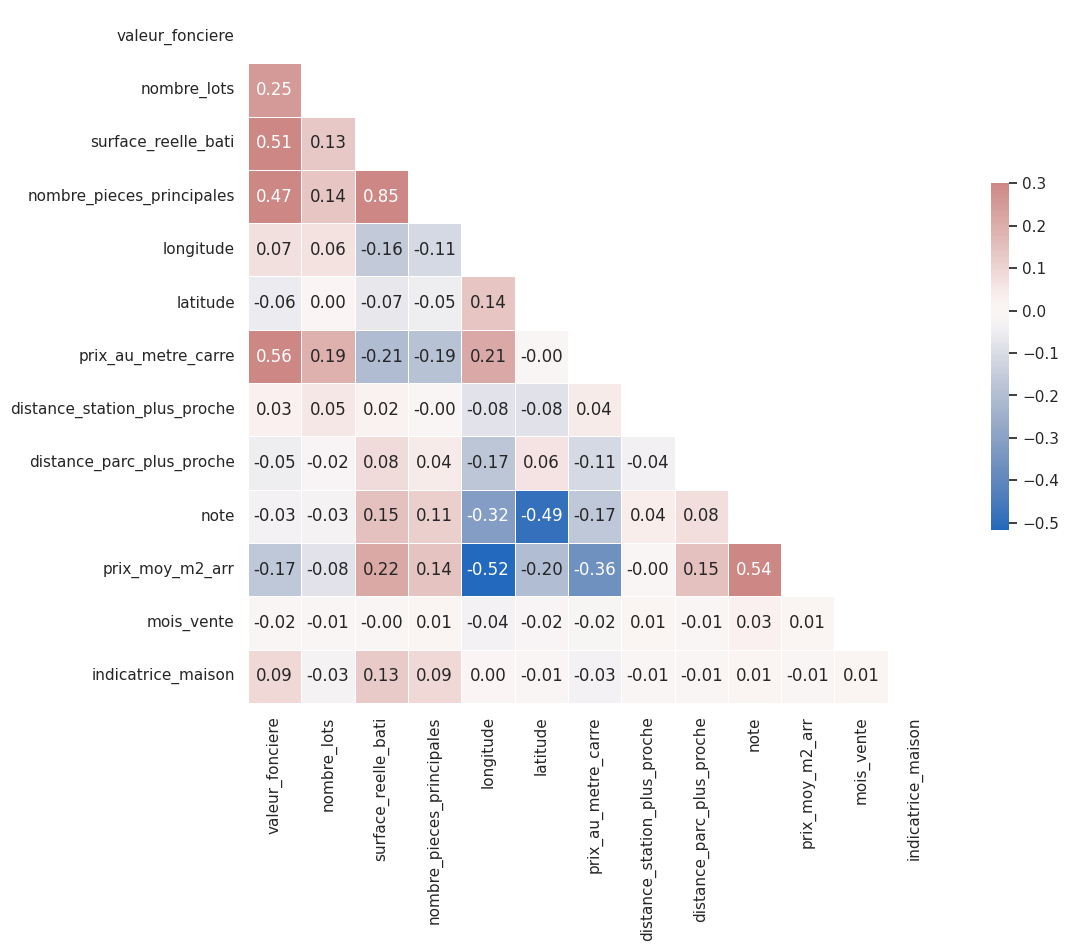

In [91]:
sns.set_theme(style="white")
corr_paris = df_paris_num.corr()
mask = np.triu(np.ones_like(corr_paris, dtype=bool))
f, ax = plt.subplots(figsize=(13, 9))
cmap = sns.color_palette("vlag", as_cmap=True)

sns.heatmap(corr_paris, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

#**6. Modélisation sur Paris**

## 6.1 Préparation du dataset

Nous voulons nous assurer que notre dataset ne comporte aucune valeur manquante dans les colonnes essentielles. C'est bien le cas avec le travail réalisé avant. Effectivement, étant donné l'unicité de chaque bien, il n'était pas possible de substituer certaines valeurs par une moyenne ou une médiane.

In [92]:
df_paris.isnull().sum()

id_mutation                     0
date_mutation                   0
nature_mutation                 0
valeur_fonciere                 0
adresse_nom_voie                0
code_commune                    0
nom_commune                     0
code_departement                0
nombre_lots                     0
type_local                      0
surface_reelle_bati             0
nombre_pieces_principales       0
longitude                       0
latitude                        0
prix_au_metre_carre             0
arrondissement                  0
nom_station                     0
distance_station_plus_proche    0
nom_ev                          0
distance_parc_plus_proche       0
note                            0
prix_moy_m2_arr                 0
mois_vente                      0
indicatrice_maison              0
dtype: int64

Nous allons maintenant transformer nos variables qualitatives en variables quantitatives. Nous l'avons déjà réalisé en créant la variable indicatrice_maison valant 1 si c'est une maison, 0 si c'est un appartement.

In [93]:
df_paris['type_voie'] = df_paris['adresse_nom_voie'].str.split().str[0]
df_paris['type_voie'].unique()

array(['RUE', 'BD', 'PAS', 'AV', 'QUAI', 'ALL', 'VC', 'IMP', 'VLA', 'SQ',
       'CRS', 'CITE', 'COUR', 'PL', 'VOIE', 'ALLEE', 'VIL', 'DU'],
      dtype=object)

On regarde les différents types de voies, et on va transformer la variable type_voie en une variable quantitative. On associe un chiffre entre 1 et 7 selon la taille, de la voie. Mais d'abord, on retire les lignes qui correspondent à une type de voie 'VC' ou 'DU' car il n'y en que 6, et ne sont pas des voies traditionnelles.

In [94]:
df_paris = df_paris.query('type_voie not in ["VC", "DU"]')

In [95]:
def attribuer_voie_num(row):
    if row['type_voie'] in ["PAS", "ALL", "ALLEE", "IMP", "VLA", "VIL", "COUR", "SQ", "CITE"]:
        return 1
    elif row['type_voie'] == "QUAI":
        return 2
    elif row['type_voie'] in ["RUE", "VOIE"]:
        return 3
    elif row['type_voie'] == "PL":
        return 4
    elif row['type_voie'] == "CRS":
        return 5
    elif row['type_voie'] == "AV":
        return 6
    elif row['type_voie'] == "BD":
        return 7
    else:
        return None

df_paris['voie_num'] = df_paris.apply(attribuer_voie_num, axis=1)

Il n'y a toujours pas de valeur manquante.

In [96]:
df_paris.isnull().sum()

id_mutation                     0
date_mutation                   0
nature_mutation                 0
valeur_fonciere                 0
adresse_nom_voie                0
code_commune                    0
nom_commune                     0
code_departement                0
nombre_lots                     0
type_local                      0
surface_reelle_bati             0
nombre_pieces_principales       0
longitude                       0
latitude                        0
prix_au_metre_carre             0
arrondissement                  0
nom_station                     0
distance_station_plus_proche    0
nom_ev                          0
distance_parc_plus_proche       0
note                            0
prix_moy_m2_arr                 0
mois_vente                      0
indicatrice_maison              0
type_voie                       0
voie_num                        0
dtype: int64

Ensuite, on crée une variable one_hot_encoded_arr pour rajouter une colonne indicatrice pour chaque arrondissement.

In [97]:
one_hot_encoded_arr = pd.get_dummies(df_paris['arrondissement'], prefix='arrondissement')

df_paris = pd.concat([df_paris, one_hot_encoded_arr], axis=1)

In [98]:
df_paris.head(2)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,...,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_20
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,...,0,0,0,0,0,0,0,0,0,1
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,...,0,0,0,0,0,0,0,0,1,0


Enfin, on crée une variable annonces_arrondissement, correspondant au nombre de ventes par arrondissement, puisque cette variable peut être représentive de l'offre sur le marché.

In [99]:
offre_arr = df_paris.groupby(['arrondissement']).agg({'arrondissement':'count'})
offre_arr

,arrondissement
arrondissement,
01,56
02,74
03,125
04,65
05,101
06,80
07,141
08,90
09,192


In [100]:
df_paris['annonces_arrondissement'] = df_paris['arrondissement'].groupby(df_paris['arrondissement']).transform('count')


##6.2 Traitement du dataset

Nous nous sommes posés la question de shuffler le dataset et de le diviser pour avoir des échantillons iid avec moins de valeurs, mais nous n'avons que 6667 données, ce qui permet de le traiter dans son entièreté. On trace la distribution de la valeur foncière et prix au mètre carré pour pouvoir sélectionner le parties du dataframe qui seront pertinentes pour notre modèle.

In [101]:
df_paris.shape[0]

6667

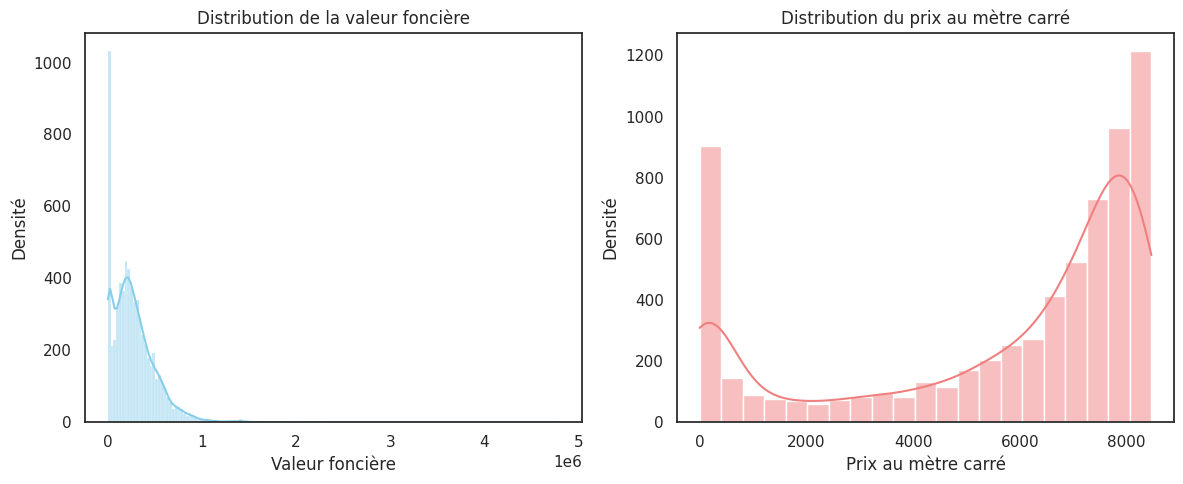

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# histogramme pour la "valeur_fonciere"
sns.histplot(df_paris['valeur_fonciere'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution de la valeur foncière')
axes[0].set_xlabel('Valeur foncière')
axes[0].set_ylabel('Densité')

# histogramme pour le "prix_au_metre_carre"
sns.histplot(df_paris['prix_au_metre_carre'], kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution du prix au mètre carré')
axes[1].set_xlabel('Prix au mètre carré')
axes[1].set_ylabel('Densité')


plt.tight_layout()
plt.show()

In [103]:
(df_paris['valeur_fonciere'] <= 1500000).mean() * 100

99.82000899955003

On s'aperçoit qu'il y a une forte proportion de biens qui ont une valeur foncière et un prix au mètre carré très faible. Nous nous apercevons rapidement qu'il y a un problème de prix symbolique ou de don. Nous allons les retirer de notre dataset pour faire notre modèle, car ces lignes sont des outliers. Nous retirons les valeurs foncières en dessous de 30000€ et les prix au mètre carré inférieurs à 1000€. On remarque aussi que 99.8% des biens ont une valeur foncière inférieure à 1 500 000€ donc on décide d'éliminer les valeurs plus hautes. On crée ainsi notre modèle.

In [104]:
modele1 = df_paris[(df_paris['prix_au_metre_carre'] > 1000) & (df_paris['valeur_fonciere'] > 30000) & (df_paris['valeur_fonciere'] <= 1500000)].copy()

In [105]:
modele1.shape[0]

5495

On tombe à 5495 données, et on retrace les distributions, qui sont maintenant sans outlier.

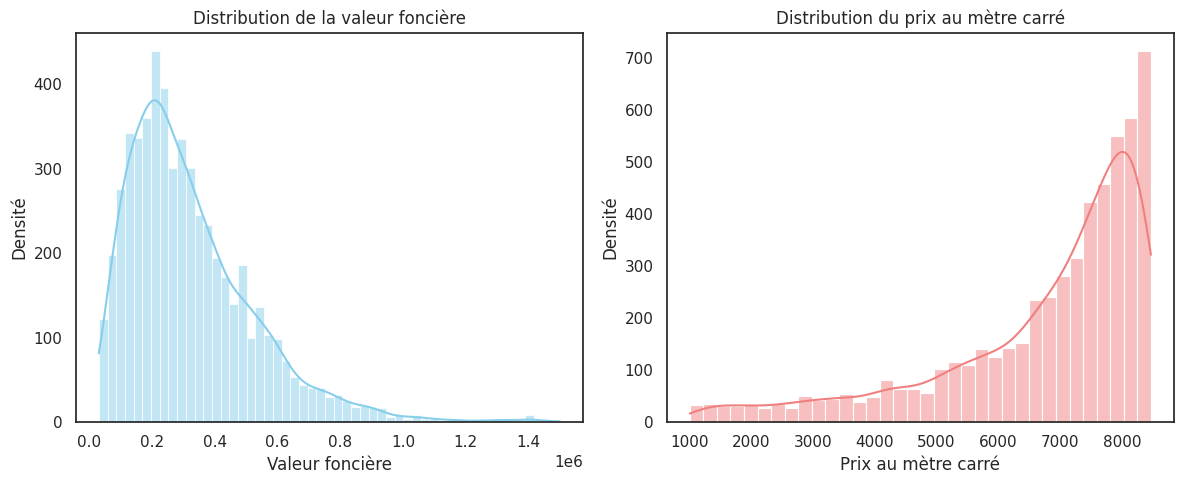

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# histogramme pour la "valeur_fonciere"
sns.histplot(modele1['valeur_fonciere'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution de la valeur foncière')
axes[0].set_xlabel('Valeur foncière')
axes[0].set_ylabel('Densité')

# histogramme pour le "prix_au_metre_carre"
sns.histplot(modele1['prix_au_metre_carre'], kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution du prix au mètre carré')
axes[1].set_xlabel('Prix au mètre carré')
axes[1].set_ylabel('Densité')

plt.tight_layout()
plt.show()

On a un pic un peu plus grand, il correspond à 200 000€ et est dû au fait que beaucoup de personnes vendent leur bien à ce prix.

In [106]:
modele1['valeur_fonciere'].mean()

323218.2456141947

Le prix moyen d'un bien est d'environ 323 000€.

In [107]:
list(df_paris.columns)

['id_mutation',
 'date_mutation',
 'nature_mutation',
 'valeur_fonciere',
 'adresse_nom_voie',
 'code_commune',
 'nom_commune',
 'code_departement',
 'nombre_lots',
 'type_local',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'longitude',
 'latitude',
 'prix_au_metre_carre',
 'arrondissement',
 'nom_station',
 'distance_station_plus_proche',
 'nom_ev',
 'distance_parc_plus_proche',
 'note',
 'prix_moy_m2_arr',
 'mois_vente',
 'indicatrice_maison',
 'type_voie',
 'voie_num',
 'arrondissement_01',
 'arrondissement_02',
 'arrondissement_03',
 'arrondissement_04',
 'arrondissement_05',
 'arrondissement_06',
 'arrondissement_07',
 'arrondissement_08',
 'arrondissement_09',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arrondissement_15',
 'arrondissement_16',
 'arrondissement_17',
 'arrondissement_18',
 'arrondissement_19',
 'arrondissement_20',
 'annonces_arrondissement']

In [108]:
colonnes_a_conserver = ['valeur_fonciere',
 'nombre_lots',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'longitude',
 'latitude',
 'prix_au_metre_carre',
 'distance_station_plus_proche',
 'distance_parc_plus_proche',
 'note',
 'prix_moy_m2_arr',
 'indicatrice_maison',
 'voie_num',
 'arrondissement_01',
 'arrondissement_02',
 'arrondissement_03',
 'arrondissement_04',
 'arrondissement_05',
 'arrondissement_06',
 'arrondissement_07',
 'arrondissement_08',
 'arrondissement_09',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arrondissement_15',
 'arrondissement_16',
 'arrondissement_17',
 'arrondissement_18',
 'arrondissement_19',
 'arrondissement_20',
 'annonces_arrondissement']

On prépare nos vecteurs X et y avec les variables explicatives et la variable expliquée, qui est ici la valeur foncière.

On va ensuite sélectionner les colonnes dont on se servira pour nos régressions. On retire aussi valeur_fonciere des variables explicatives.

In [109]:
X = modele1.copy()
X = X[colonnes_a_conserver]
y = X['valeur_fonciere']
X = X.drop('valeur_fonciere', axis=1)

On subdivise la base de données en trois parties : le set d'entraînement (utilisé pour ajuster le modèle), le set de test (pour évaluer les performances), et le set de validation. On prend 20% des données pour l'ensemble de test, et 80% pour l'entrainement, puis 25% de l'entrainement pour la validation.

In [110]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=2)
print(f' X_train shape : {X_train.shape}')
print(f' X_val shape : {X_val.shape}')
print(f' X_test shape : {X_test.shape}')

 X_train shape : (3297, 33)
 X_val shape : (1099, 33)
 X_test shape : (1099, 33)


## 6.3 Méthode des moindres carrés (OLS)

On opère la régression par OLS sur X_train.

In [111]:
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     756.5
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:58:10   Log-Likelihood:                -41667.
No. Observations:                3297   AIC:                         8.339e+04
Df Residuals:                    3267   BIC:                         8.358e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         3.247e+05   1303.880    249.052      0.000    3.22e+05    3.27e+05
nombre_lots                   7459.5610   1344.739      5.547      0.000    4822.945    1.01e+04
surface_reelle_bati           1.532e+05   2525.162     60.653      0.000    1.48e+05    1.58e+05
nombre_pieces_principales     3.368e+04   2509.433     13.420      0.000    2.88e+04    3.86e+04
longitude                    -9556.6761   5235.977     -1.825      0.068   -1.98e+04     709.453
latitude                       314.8901   5017.129      0.063      0.950   -9522.146    1.02e+04
prix_au_metre_carre           9.935e+04   1359.690     73.068      0.000    9.67e+04    1.02e+05
distance_station_plus_proche -1636.7553   1374.667     -1.191      0.234   -4332.052    1058.542
distance_parc_plus_proche      394.9358   1398.241      0.282      0.778   -2346.581    3136.452
note                          -284.6474   1208.695     -0.235      0.814   -2654.525    2085.230
prix_moy_m2_arr              -3080.6041   1338.635     -2.301      0.021   -5705.253    -455.955
indicatrice_maison            2097.8266   1322.416      1.586      0.113    -495.022    4690.675
voie_num                      2202.9024   1362.032      1.617      0.106    -467.621    4873.426
arrondissement_01             1276.3996   1299.244      0.982      0.326   -1271.015    3823.814
arrondissement_02              923.2992   1290.609      0.715      0.474   -1607.185    3453.783
arrondissement_03             2700.1422   1381.003      1.955      0.051      -7.577    5407.862
arrondissement_04               -8.7544   1296.293     -0.007      0.995   -2550.384    2532.875
arrondissement_05             -429.6986   1302.149     -0.330      0.741   -2982.809    2123.412
arrondissement_06             1098.4104   1246.296      0.881      0.378   -1345.190    3542.010
arrondissement_07            -1699.6728   1212.537     -1.402      0.161   -4077.082     677.737
arrondissement_08             -630.4037   1384.633     -0.455      0.649   -3345.240    2084.433
arrondissement_09            -1773.6652   1470.170     -1.206      0.228   -4656.213    1108.883
arrondissement_10             1420.0749   1165.594      1.218      0.223    -865.294    3705.443
arrondissement_11             -545.3062   1633.240     -0.334      0.738   -3747.584    2656.971
arrondissement_12             3253.8970   1948.657      1.670      0.095    -566.815    7074.609
arrondissement_13               57.6258   2332.772      0.025      0.980   -4516.218    4631.469
arrondissement_14            -1057.5959   2090.138     -0.506      0.613   -5155.709    3040.517
arrondissement_15            -2673.9336   2735.318     -0.978      0.328   -8037.045    2689.178
arrondissement_16            -3153.3742   2309.562     -1.365      0.172   -

On remarque plusieurs choses : le R² est de 0.87, ce qui suggère que les variables explicatives permettent plutôt bien de décrire les valeurs foncières. On remarque que nous avons certaines p-values à 0.000 ou très faibles, et donc une très forte significativité de celles-ci. Cependant, nous avons également des variables beaucoup moins significatives, comme la latitude, la distance à l'espaces vert le plus proche, ou encore la note de l'arrondissement. On remarque également, que contrairement à la latitude, la longitude est assez significative. Cela s'explique par le fait que les arrondissements les plus chers se situent plutot dans l'ouest parisien, et que le sud ou le nord n'impactent peu. De plus, on remarque que l'indicatrice des arrondissements est très significative dans certains, comme le 18e ou le 20e, mais pas du tout dans le 13e ou le 4e. On remarque aussi que les coefficients les plus grands sont la surface réelle du bien, le nombre de pièces et le prix au mètre carré, ce qui est cohérent. Le coefficient de la distance à la station la plus proche est négatif et de -1636, ce qui signifie qu'en moyenne, pour chaque unité d'augmentation de la distance à la station de métro la plus proche, la valeur du bien immobilier diminue de 1636€, toutes choses égales par ailleurs, ce qui est cohérent, car avoir des transports accessibles est un avantage. En revanche, le coefficient de la distance à l'espace vert le plus proche est positif, ce qui signifie que plus on est loin d'un espace vert, plus le bien est cher. Cela parait incohérent, mais comme la p-valeur est de 0.778, ce coefficient n'est pas significatif.

## 6.4 Régression avec Scikit-Learn

On commence par définir l'erreur absolue moyenne entre les valeurs réelles et les valeurs prédites. Cette métrique permet d'évaluer la précision du modèle, et plus elle se rapproche de zéro, plus le modèle est précis. Il est important de noter que cette mesure est exprimée dans la même unité que les valeurs du modèle. Par conséquent, pour évaluer précisément la précision, il est recommandé de la comparer aux valeurs réelles, notamment aux prix dans ce contexte.

In [113]:
def ema_score(pred, actual):
    return np.mean(np.abs(np.exp(actual) - np.exp(pred)))

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

train_pred = lr.predict(X_train_scaled)
val_pred = lr.predict(X_val_scaled)

print(f'Linear Regression (train) R^2: {lr.score(X_train_scaled, y_train)}')
print(f'Linear Regression (validation) R^2: {lr.score(X_val_scaled, y_val)}')

print("\n EMA du Train:", round(mean_absolute_error(y_train, train_pred),4))
print("EMA de Validation:", round(mean_absolute_error(y_val, val_pred),4))

Linear Regression (train) R^2: 0.8703865035052486
Linear Regression (validation) R^2: 0.8745852689684499

 EMA du Train: 46805.7375
EMA de Validation: 46533.6158


On constate que les R² sont de 0.87 comme dans l'autre régression. L'erreur moyenne absolue est d'environ 46000€, ce qui est une erreur correcte comparée à la valeur foncière moyenne calculée plus haut. On peut alors dire que le modèle est d'une précision correcte.

Traçons maintenant les valeurs foncières réelles comparées à celles prédites.

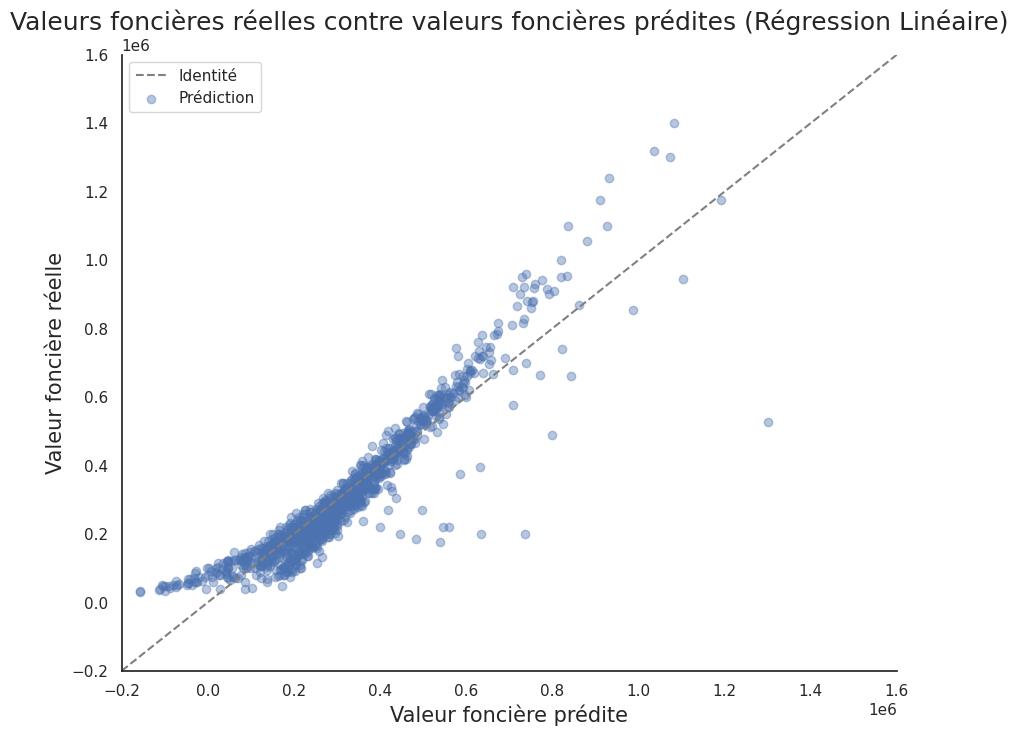

In [114]:
plt.figure(figsize=(10, 8))

plt.xlim(-2e5, 1.6e6)
plt.ylim(-2e5, 1.6e6)
plt.plot([-2e5, 1.6e6], [-2e5, 1.6e6], label='Identité', linestyle='--', color='gray')

plt.scatter(val_pred, y_val, alpha=0.4, label='Prédiction')

sns.despine()

plt.ylabel('Valeur foncière réelle', size=15)
plt.xlabel('Valeur foncière prédite', size=15)
plt.title('Valeurs foncières réelles contre valeurs foncières prédites (Régression Linéaire)', size=18)

plt.legend()

plt.savefig('actual_plot', bbox_inches='tight', dpi=400)
plt.show()

Les prédictions sont assez proches de la fonction identité, ce qui est cohérent avec le R² de 0.87. Cependant, on observe que le modèle est très satisfaisant pour les prix entre 50 000€ et 600 000€, mais qu'au delà, il y a une dispersion, avec une valeur foncière prédite plus faible que la valeur foncière réelle.

Traçons maintenant la distribution des résidus.

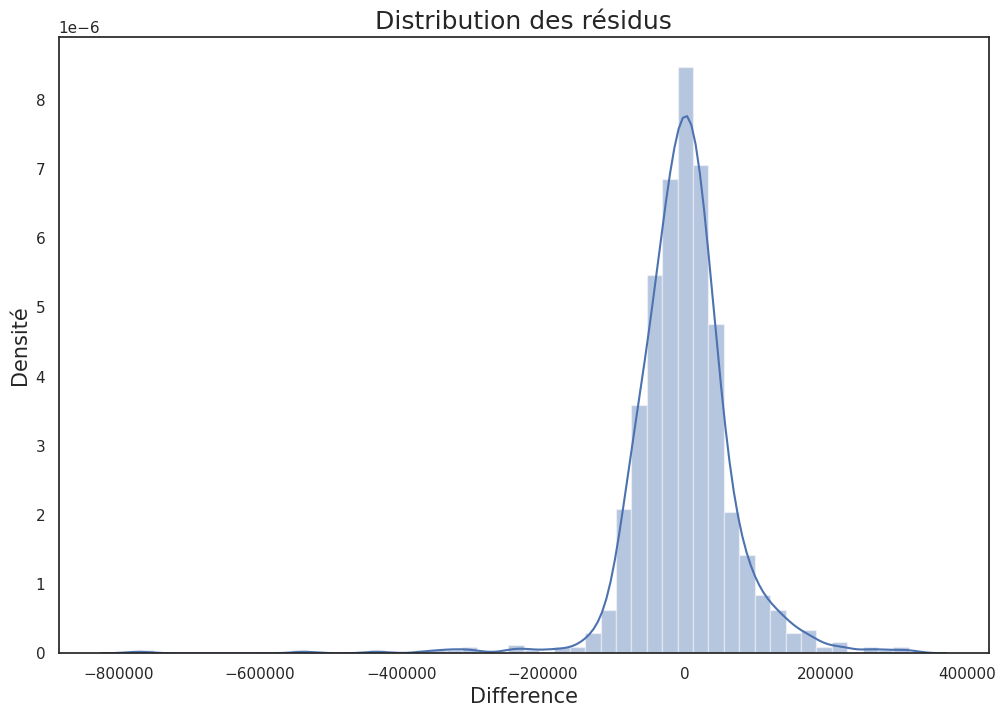

In [115]:
plt.figure(figsize=(12,8))
sns.distplot(y_val - val_pred)
plt.title('Distribution des résidus', size = 18)
plt.xlabel('Difference', size = 15);
plt.ylabel('Densité', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

Les résidus sont distribués selon une loi normale centrée en 0, ce qui est cohérent avec l'hypothèse habituelle de normalité des erreurs.

## 6.5 Régularisation avec la méthode de Lasso

L'objectif principal de la méthode de Lasso est de pénaliser les coefficients des caractéristiques du modèle de régression pour éviter le surajustement (overfitting) et pour effectuer une sélection de caractéristiques automatique. La méthode utilise une pénalité (alpha) L1 sur les coefficients du modèle. Plus alpha augmente, plus les coefficients tendent vers 0 à cause de la pénalité.

In [125]:
kf = KFold(n_splits=5, shuffle=True, random_state = 21)

alphavec = 10**np.linspace(-3,3,500)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV validation R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')

train_pred = lasso_model.predict(X_train_scaled)
y_val_pred_lasso = lasso_model.predict(X_val_scaled)

print('EMA pour le train en LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('EMA pour la validation en LassoCV:', round(mean_absolute_error(y_val, y_val_pred_lasso),4))

LassoCV alpha: 1000.0
LassoCV train R^2: 0.870
LassoCV validation R^2: 0.875
EMA pour le train en LassoCV: 46850.4286
EMA pour la validation en LassoCV: 46445.2427


Avec la méthode de Lasso, on rétrouve un R² égal à 0.87 et une erreur moyenne absolue semblable à celle vue précédemment. On a alpha très grand, ce qui pousse beaucoup de coefficients à 0.

In [126]:
alpha = 1000
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
indices_caracteristiques_non_nulles = np.where(coefficients != 0)[0]
colonnes_non_nulles = X.columns[indices_caracteristiques_non_nulles]
print("Colonnes non nulles :", list(colonnes_non_nulles))

Colonnes non nulles : ['nombre_lots', 'surface_reelle_bati', 'nombre_pieces_principales', 'prix_au_metre_carre', 'distance_station_plus_proche', 'indicatrice_maison', 'voie_num', 'arrondissement_01', 'arrondissement_03', 'arrondissement_05', 'arrondissement_07', 'arrondissement_09', 'arrondissement_10', 'arrondissement_11', 'arrondissement_17', 'arrondissement_18', 'arrondissement_20']


Ensuite, on regarde quelles variables ont dorénavant un coefficient nul, et quel est le coefficient non nul des autres variables.

In [127]:
lasso_coefficients_df = pd.DataFrame({'Colonne': X.columns, 'Coefficient': lasso.coef_})
lasso_coefficients_non_nuls = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0]
print("Colonnes avec des coefficients non nuls et leurs coefficients :")
print(lasso_coefficients_non_nuls[['Colonne', 'Coefficient']])

print("\nColonnes avec des coefficients nuls :")
colonnes_coefficients_nuls = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] == 0]['Colonne']
print(colonnes_coefficients_nuls.tolist())

Colonnes avec des coefficients non nuls et leurs coefficients :
                         Colonne    Coefficient
0                    nombre_lots    6475.255004
1            surface_reelle_bati  152866.024826
2      nombre_pieces_principales   33064.104758
5            prix_au_metre_carre   98163.270735
6   distance_station_plus_proche    -793.522623
10            indicatrice_maison     842.605081
11                      voie_num    1264.225019
12             arrondissement_01     429.228244
14             arrondissement_03     789.426103
16             arrondissement_05    -108.556112
18             arrondissement_07    -934.660000
20             arrondissement_09    -866.825557
21             arrondissement_10     193.497890
22             arrondissement_11   -1728.950601
28             arrondissement_17     -79.601297
29             arrondissement_18   -2032.421465
31             arrondissement_20    1958.593633

Colonnes avec des coefficients nuls :
['longitude', 'latitude', 'distan

On trace alors les valeurs foncières réelles en fonction de celles prédites après la méthode de Lasso, mais on remarque la même chose que précédemment, que le modèle est plutôt bon en dessous de 600 000€, mais au delà, les prix réels sont plus grands que ceux prédits.

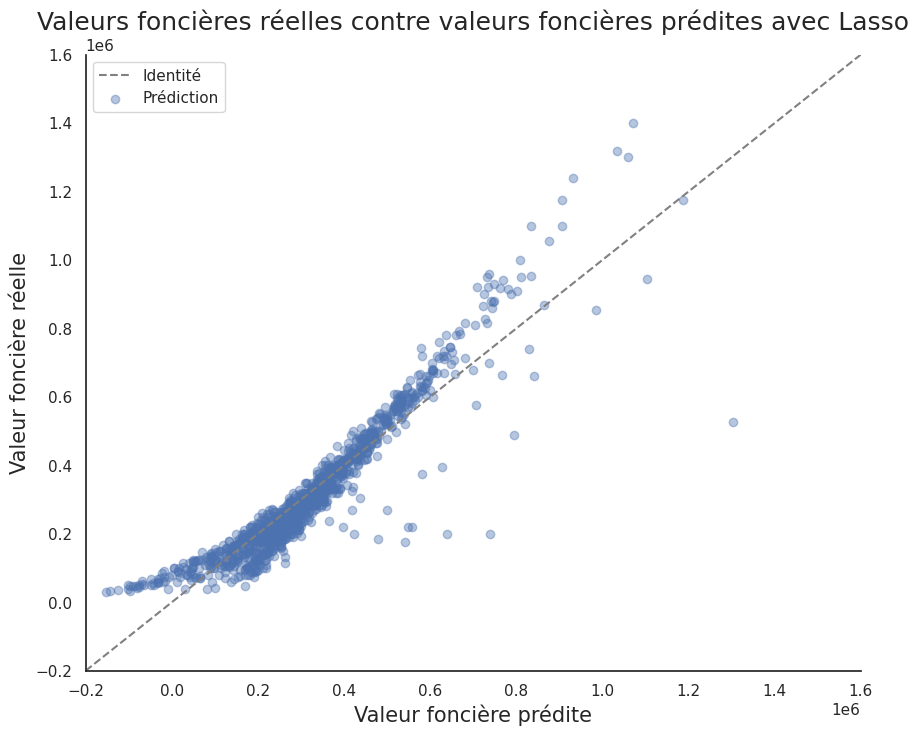

In [129]:
plt.figure(figsize=(10, 8))

plt.xlim(-2e5, 1.6e6)
plt.ylim(-2e5, 1.6e6)
plt.plot([-2e5, 1.6e6], [-2e5, 1.6e6], label='Identité', linestyle='--', color='gray')

plt.scatter(y_val_pred_lasso, y_val, alpha=0.4, label='Prédiction')

sns.despine()

plt.ylabel('Valeur foncière réelle', size=15)
plt.xlabel('Valeur foncière prédite', size=15)
plt.title('Valeurs foncières réelles contre valeurs foncières prédites avec Lasso', size=18)

plt.legend()

plt.savefig('actual_plot', bbox_inches='tight', dpi=400)
plt.show()

## 6.6 Importance de chaque coefficient

Maintenant, nous allons nous intéresser à l'importance de chaque coefficient, pour déterminer ce qui influence le plus les prix de l'immobilier.

Voici d'abord les coefficients numériques, puis leur représentation graphique.

In [130]:
X_train.columns

Index(['nombre_lots', 'surface_reelle_bati', 'nombre_pieces_principales',
       'longitude', 'latitude', 'prix_au_metre_carre',
       'distance_station_plus_proche', 'distance_parc_plus_proche', 'note',
       'prix_moy_m2_arr', 'indicatrice_maison', 'voie_num',
       'arrondissement_01', 'arrondissement_02', 'arrondissement_03',
       'arrondissement_04', 'arrondissement_05', 'arrondissement_06',
       'arrondissement_07', 'arrondissement_08', 'arrondissement_09',
       'arrondissement_10', 'arrondissement_11', 'arrondissement_12',
       'arrondissement_13', 'arrondissement_14', 'arrondissement_15',
       'arrondissement_16', 'arrondissement_17', 'arrondissement_18',
       'arrondissement_19', 'arrondissement_20', 'annonces_arrondissement'],
      dtype='object')

In [131]:
#Les coefficients numériques

coefs_df = pd.DataFrame({'Coefficient': fit.params})
coefs_df=coefs_df.drop(['const'],axis=0)
coefs_df

,Coefficient
nombre_lots,7459.560963
surface_reelle_bati,153159.545623
nombre_pieces_principales,33675.601065
longitude,-9556.676105
latitude,314.890130
prix_au_metre_carre,99350.139921
distance_station_plus_proche,-1636.755301
distance_parc_plus_proche,394.935774
note,-284.647397
prix_moy_m2_arr,-3080.604120


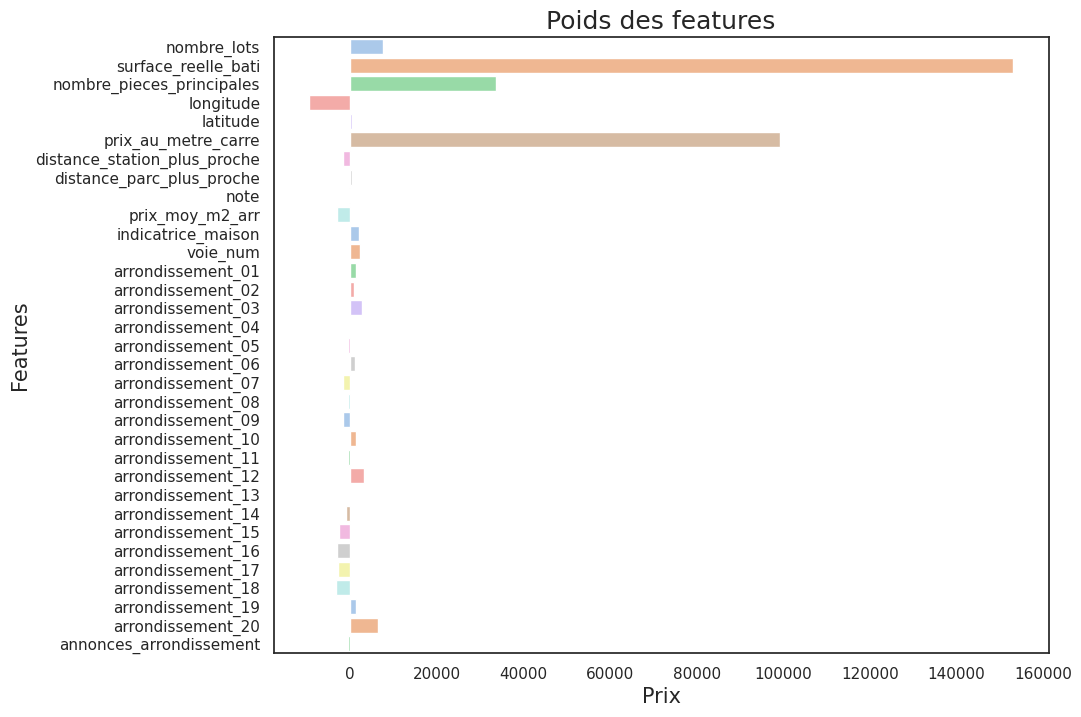

In [132]:
#La représentation graphique des coefficients numériques

y_values = coefs_df['Coefficient']
x_values = list(coefs_df.index)

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=y_values, y=x_values, palette=("pastel"))
ax.set_title('Poids des features', size=18)
ax.set_xlabel('Prix', size=15)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

Grâce au graphique ci-dessus, nous pouvons voir que certains coefficients influent beaucoup plus que d'autres : notamment la surface réelle du batîment, le nombre de pièces et le prix au mètre carré. Un autre coefficient notable, comme relevé précédemment, est la longitude. C'est le coefficient négatif le plus important, et de loin.

#**7. Conclusion**

Le but de ce projet était de prédire les prix de l'immobilier parisien en fonction de variables que nous avons choisies. Nous avons commencé par faire des graphiques et des cartes afin de décrire les ventes d'immobilier en Ile-de-France. Cela nous a permis de choisir les variables à étudier. Nous avons ensuite rajouté des variables que nous pensions auraient un fort impact : les distances aux gares et parcs. Nous avons ensuite construit notre modèle de prédiction des prix grâce à plusieurs méthodes et évalué l'importance des coefficients. Dans l'idéal, nous pourrions inclure plus de ventes dans le modèle. En effet, nous n'avons étudié que celles de 2022. Cependant, cela représente un nombre de données trop important pour nos ordinateurs. Toutefois, il aurait été intéressant de se réaliser notre analyse sur une plus grande base de données et peut-être de voir l'influence de l'année sur le prix. Enfin, nous pensons avoir appliqué la majorité des points vus en cours, et sommes satisfaits d'avoir appris tout cela. Finalement, nous pensons avoir mis en pratique la majeure partie des concepts abordés pendant les cours, et nous sommes satisfaites d'avoir assimilé ces connaissances.